Name : Sanjeev Kumar Khatri

Roll no : 23

Group : CS

Assignment : 05

Githublink : https://github.com/darkamgel/machinelearning-LAB


Practical Assignment - 5

1. Classification – Detecting Poor Answers 
2. Sketching our roadmap Learning to classify classy 
3. answers Fetching the data Creating our first classifier 
4. Deciding how to improve Using logistic regression

In [1]:
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/sanju/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import os
import re
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm # we all love nice progress bars, don't we?
try:
    import ujson as json  # UltraJSON if available
except:
    print("You can also use the normal json module, but you get a XXX speedup if you use ujson instead.")
    raise

DATA_DIR = r'data'

YEAR = 2017 

fn_posts_all = os.path.join(DATA_DIR, "Posts.xml")
fn_posts = os.path.join(DATA_DIR, "posts-%i.xml" % YEAR)

fn_filtered = os.path.join(DATA_DIR, "filtered-%i.tsv" % YEAR)
fn_filtered_meta = os.path.join(DATA_DIR, "filtered-%i-meta.json" % YEAR)

SAMPLE_DIR = '%i' % YEAR
if not os.path.exists(SAMPLE_DIR):
    os.mkdir(SAMPLE_DIR)

if not os.path.exists(os.path.join(SAMPLE_DIR, 'data')):
    os.mkdir(os.path.join(SAMPLE_DIR, 'data'))

fn_sample = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample.tsv"))
fn_sample_meta = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample-meta.json"))
print("sample posts: %s" % fn_sample)
print("sample meta: %s" % fn_sample_meta)

CHART_DIR = os.path.join(SAMPLE_DIR, "charts")
if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)


sample posts: /Users/sanju/Files/KATHMANDU UNIVERSITY/7th sem/Machine learning/Assignment/machinelearning-LAB/week-5/2017/data/sample.tsv
sample meta: /Users/sanju/Files/KATHMANDU UNIVERSITY/7th sem/Machine learning/Assignment/machinelearning-LAB/week-5/2017/data/sample-meta.json


In [3]:
year_match = re.compile(r'^\s+<row [^>]*CreationDate="(\d+)-')
size = os.path.getsize(fn_posts_all)

def get_year(line):
    m = year_match.match(line)
    if m is None:
        return None
    return int(m.group(1))

print("Extracting all posts from %i ..." % YEAR)
with open(fn_posts_all, 'r', encoding='utf-8') as fa, open(fn_posts, 'w', encoding='utf-8') as f_year:
    f_year.write('<?xml version="1.0" encoding="utf-8"?><posts>\n')    
    
    right = size//2
    delta = right
    
    while True:
        fa.seek(right)
        fa.readline()
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        assert delta > 0
        
        if year>YEAR:
            right -= delta
        elif year<YEAR:
            right += delta
        else:
            break
            
    left = right//2
    delta = left
    while True:
        fa.seek(left)
        fa.readline()
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        if delta == 0:
            break
        
        if year<YEAR:
            left += delta
            
        else:
            left, right = left-delta, left

    while True:
        line = fa.readline()
        year = get_year(line)
        if year == YEAR:
            f_year.write(line)
        elif year is None or year > YEAR:
            break
        
    f_year.write('</posts>')
print('... done!')

Extracting all posts from 2017 ...
... done!


In [4]:
from dateutil import parser as dateparser

from operator import itemgetter
from lxml import etree

NUM_ROWS = 5113519 

filtered_meta = {
    'question': {}, 
    'total': 0 
}


code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE | re.DOTALL)
link_match = re.compile('<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)
tag_match = re.compile('<[^>]*>', re.MULTILINE | re.DOTALL)
whitespace_match = re.compile(r'\s+', re.MULTILINE | re.DOTALL)

def extract_features_from_body(s):
    '''
    This method creates features from the raw post. It already contains all 
    features that we will use throughout the chapter.
    '''
    num_code_lines = 0
    link_count_in_code = 0
    code_free_s = s

    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub(' ', code_free_s)

    
        link_count_in_code += len(link_match.findall(match_str))

    links = link_match.findall(s)
    link_count = len(links) - link_count_in_code

    html_free_s = tag_match.sub(' ', code_free_s)
    
    text = html_free_s
    for link in links:
        if link.lower().startswith('http://'):
            text = text.replace(link, ' ')

    text = whitespace_match.sub(' ', text)
    num_text_tokens = text.count(' ')

    return text, num_text_tokens, num_code_lines, link_count

num_questions = 0
num_answers = 0

def parsexml(fn):
    global num_questions, num_answers

    counter = 0

    it = map(itemgetter(1), etree.iterparse(fn, events=('start',)))
    
    root = next(it)
    
    for counter, elem in enumerate(tqdm(it, total=NUM_ROWS)):
        
        if elem.tag != 'row':
            continue
            
        Id = int(elem.get('Id'))
        PostTypeId = int(elem.get('PostTypeId'))
        Score = int(elem.get('Score'))

        if PostTypeId == 1:
            num_questions += 1            
            ParentId = -1
            filtered_meta['question'][Id] = []
            
        elif PostTypeId == 2:
            num_answers += 1
            ParentId = int(elem.get('ParentId'))
            if not ParentId in filtered_meta['question']:
                # question is not from the same year so we have already dropped it
                continue

            filtered_meta['question'][ParentId].append((Id, Score))

        else:
            continue

        Text, NumTextTokens, NumCodeLines, LinkCount = extract_features_from_body(elem.get('Body'))

        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
            
        values = (Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text)

        yield values

    print("Found %i posts" % counter)

if any(not os.path.exists(fn) for fn in [fn_filtered, fn_filtered_meta]):
    total = 0
    with open(fn_filtered, "w", encoding='utf-8') as f:
        for values in parsexml(fn_posts):
            line = "\t".join(map(str, values))
            f.write(line + "\n")
            total += 1
    filtered_meta['total'] = total
                
    with open(fn_filtered_meta, "w") as f:
        json.dump(filtered_meta, f)
    
    print("#qestions: %i" % num_questions)
    print("#answers: %i" % num_answers)
    
else:
    print("Skipping the conversion step, loading data from %s ..." % fn_filtered_meta)
    filtered_meta = json.load(open(fn_filtered_meta, "r"))
    print("... done!")

Skipping the conversion step, loading data from data/filtered-2017-meta.json ...
... done!


In [5]:
NUM_QUESTION_SAMPLE = 10000

posts_to_keep = set()
found_questions = 0

question = filtered_meta['question']

for ParentId, posts in tqdm(sorted(question.items()), desc="Stage 1:"):
    assert ParentId != -1

    if len(posts) < 2:
        continue

    neg_score_ids = []
    pos_score_ids = []
    
    for Id, Score in posts:
        if Score < 0:
            neg_score_ids.append((Score, Id))
        elif Score > 0:
            pos_score_ids.append((Score, Id))   

    if pos_score_ids and neg_score_ids:
        posts_to_keep.add(int(ParentId))

        posScore, posId = sorted(pos_score_ids)[-1]
        posts_to_keep.add(posId)

        negScore, negId = sorted(neg_score_ids)[0]
        posts_to_keep.add(negId)

        found_questions += 1

    if found_questions >= NUM_QUESTION_SAMPLE:
        break

/var/folders/z3/m6bp6bmn1lj8zyhyktg7y1th0000gn/T/ipykernel_11176/3044265997.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ParentId, posts in tqdm(sorted(question.items()), desc="Stage 1:"):


Stage 1::   0%|          | 0/2128811 [00:00<?, ?it/s]

In [6]:
already_written = set()
sample_meta = defaultdict(dict)

total = 0
kept = 0

with open(fn_sample, "w", encoding='utf-8') as f:
    for line in tqdm(open(fn_filtered, 'r', encoding='utf-8'), total=NUM_ROWS, desc="Stage 2:"):
        Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text = line.split("\t")

        Text = Text.strip()

        total += 1

        Id = int(Id)
        if Id in posts_to_keep:
            if Id in already_written:
                print(Id, "is already written")
                continue

            # setting meta info
            post = sample_meta[Id]
            post['ParentId'] = int(ParentId)
            post['Score'] = int(Score)
            post['NumTextTokens'] = int(NumTextTokens)
            post['NumCodeLines'] = int(NumCodeLines)
            post['LinkCount'] = int(LinkCount)
            post['idx'] = kept  # index into the TSV file

            if int(ParentId) == -1:
                q = sample_meta[Id]

                if not 'Answers' in q:
                    q['Answers'] = []

            else:
                q = sample_meta[int(ParentId)]

                if 'Answers' not in q:
                    q['Answers'] = [Id]
                else:
                    q['Answers'].append(Id)

            f.writelines("%s\t%s\n" % (Id, Text))
            kept += 1

with open(fn_sample_meta, "w") as fm:
    json.dump(sample_meta, fm)

print("read:", total)
print("kept:", kept)

/var/folders/z3/m6bp6bmn1lj8zyhyktg7y1th0000gn/T/ipykernel_11176/4231339250.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm(open(fn_filtered, 'r', encoding='utf-8'), total=NUM_ROWS, desc="Stage 2:"):


Stage 2::   0%|          | 0/5113519 [00:00<?, ?it/s]

read: 4654476
kept: 30000


In [7]:
def load_meta(fn):
    meta = json.load(open(fn, "r"))
    
    # JSON only allows string keys, changing that to int
    for key in list(meta.keys()):
        meta[int(key)] = meta[key]
        del meta[key]

    return meta

meta = load_meta(fn_sample_meta)

def save_png(name):
    fn = 'B09124_04_%s.png'%name 
    plt.savefig(os.path.join(CHART_DIR, fn), bbox_inches="tight")

In [8]:
all_answers = sorted([a for a, v in meta.items() if v['ParentId'] != -1])

In [9]:
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
print(np.unique(Y, return_counts=True))

(array([False,  True]), array([10000, 10000]))


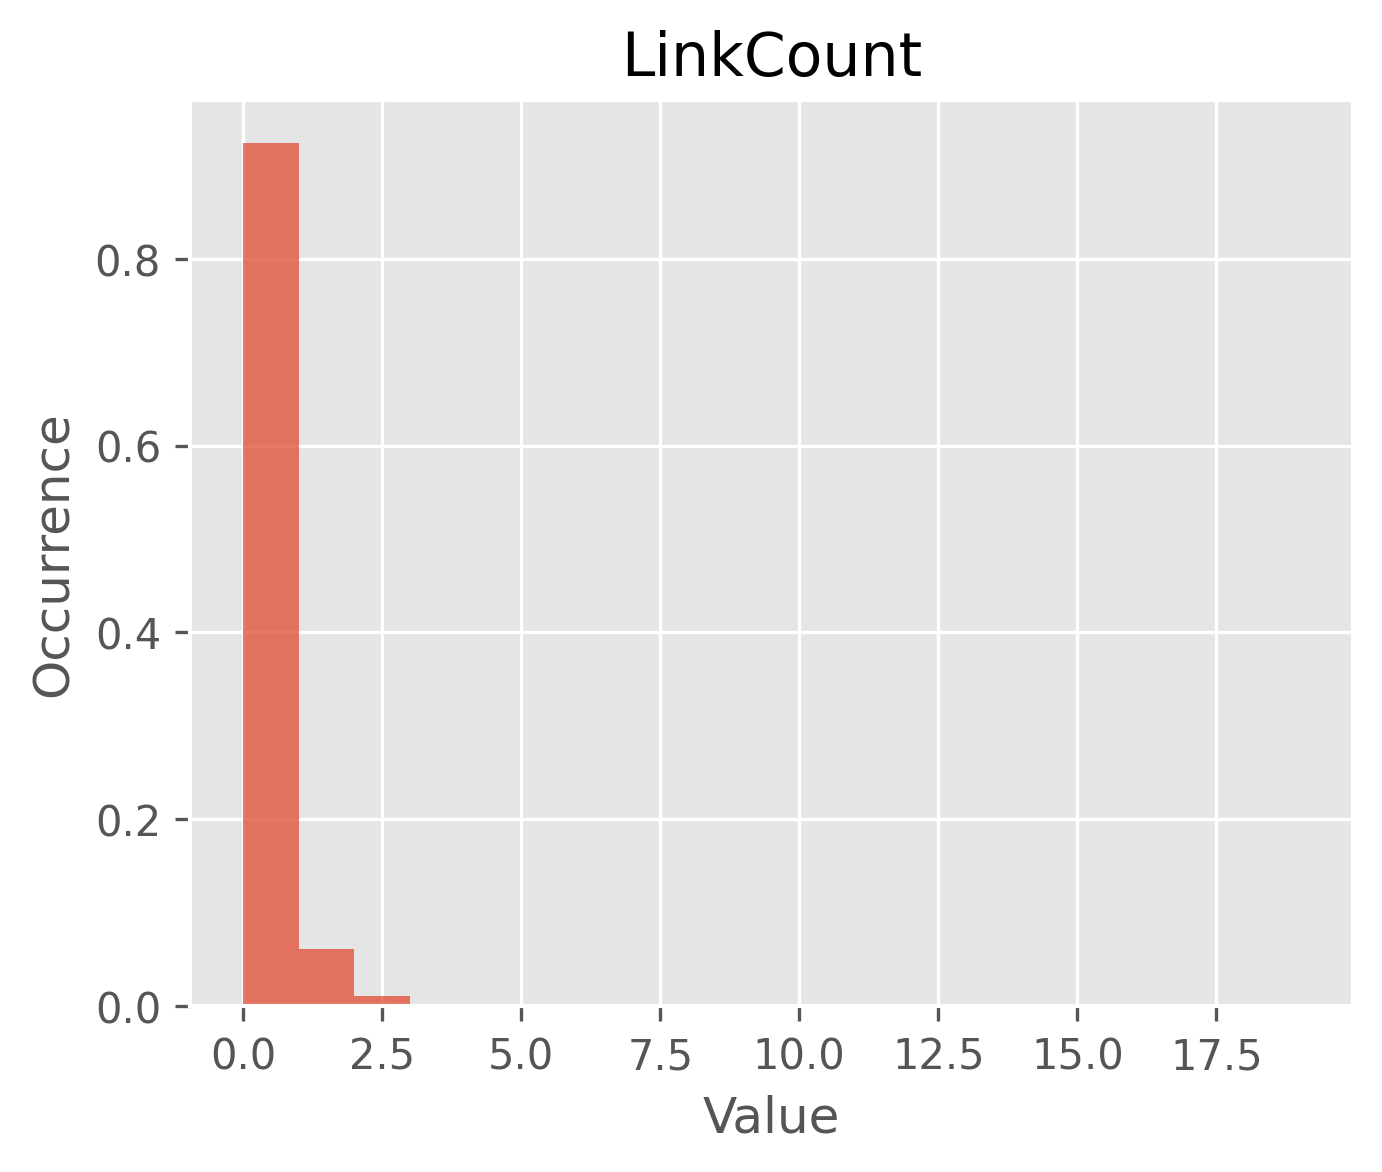

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

X = np.asarray([[meta[aid]['LinkCount']] for aid in all_answers])

plt.figure(figsize=(5,4), dpi=300) 

plt.title('LinkCount')
plt.xlabel('Value')
plt.ylabel('Occurrence')

n, bins, patches = plt.hist(X, density=True, stacked=True, bins=range(max(X.ravel())-min(X.ravel())), alpha=0.75)

plt.grid(True)
save_png('01_feat_hist_LinkCount')

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

N_FOLDS = 10
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=0)

scores = []
for train, test in tqdm(cv.split(X, Y)):
    clf = KNeighborsClassifier()
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 

/var/folders/z3/m6bp6bmn1lj8zyhyktg7y1th0000gn/T/ipykernel_11176/3799484060.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for train, test in tqdm(cv.split(X, Y)):


0it [00:00, ?it/s]

Mean(scores)=0.49860	Stddev(scores)=0.01469


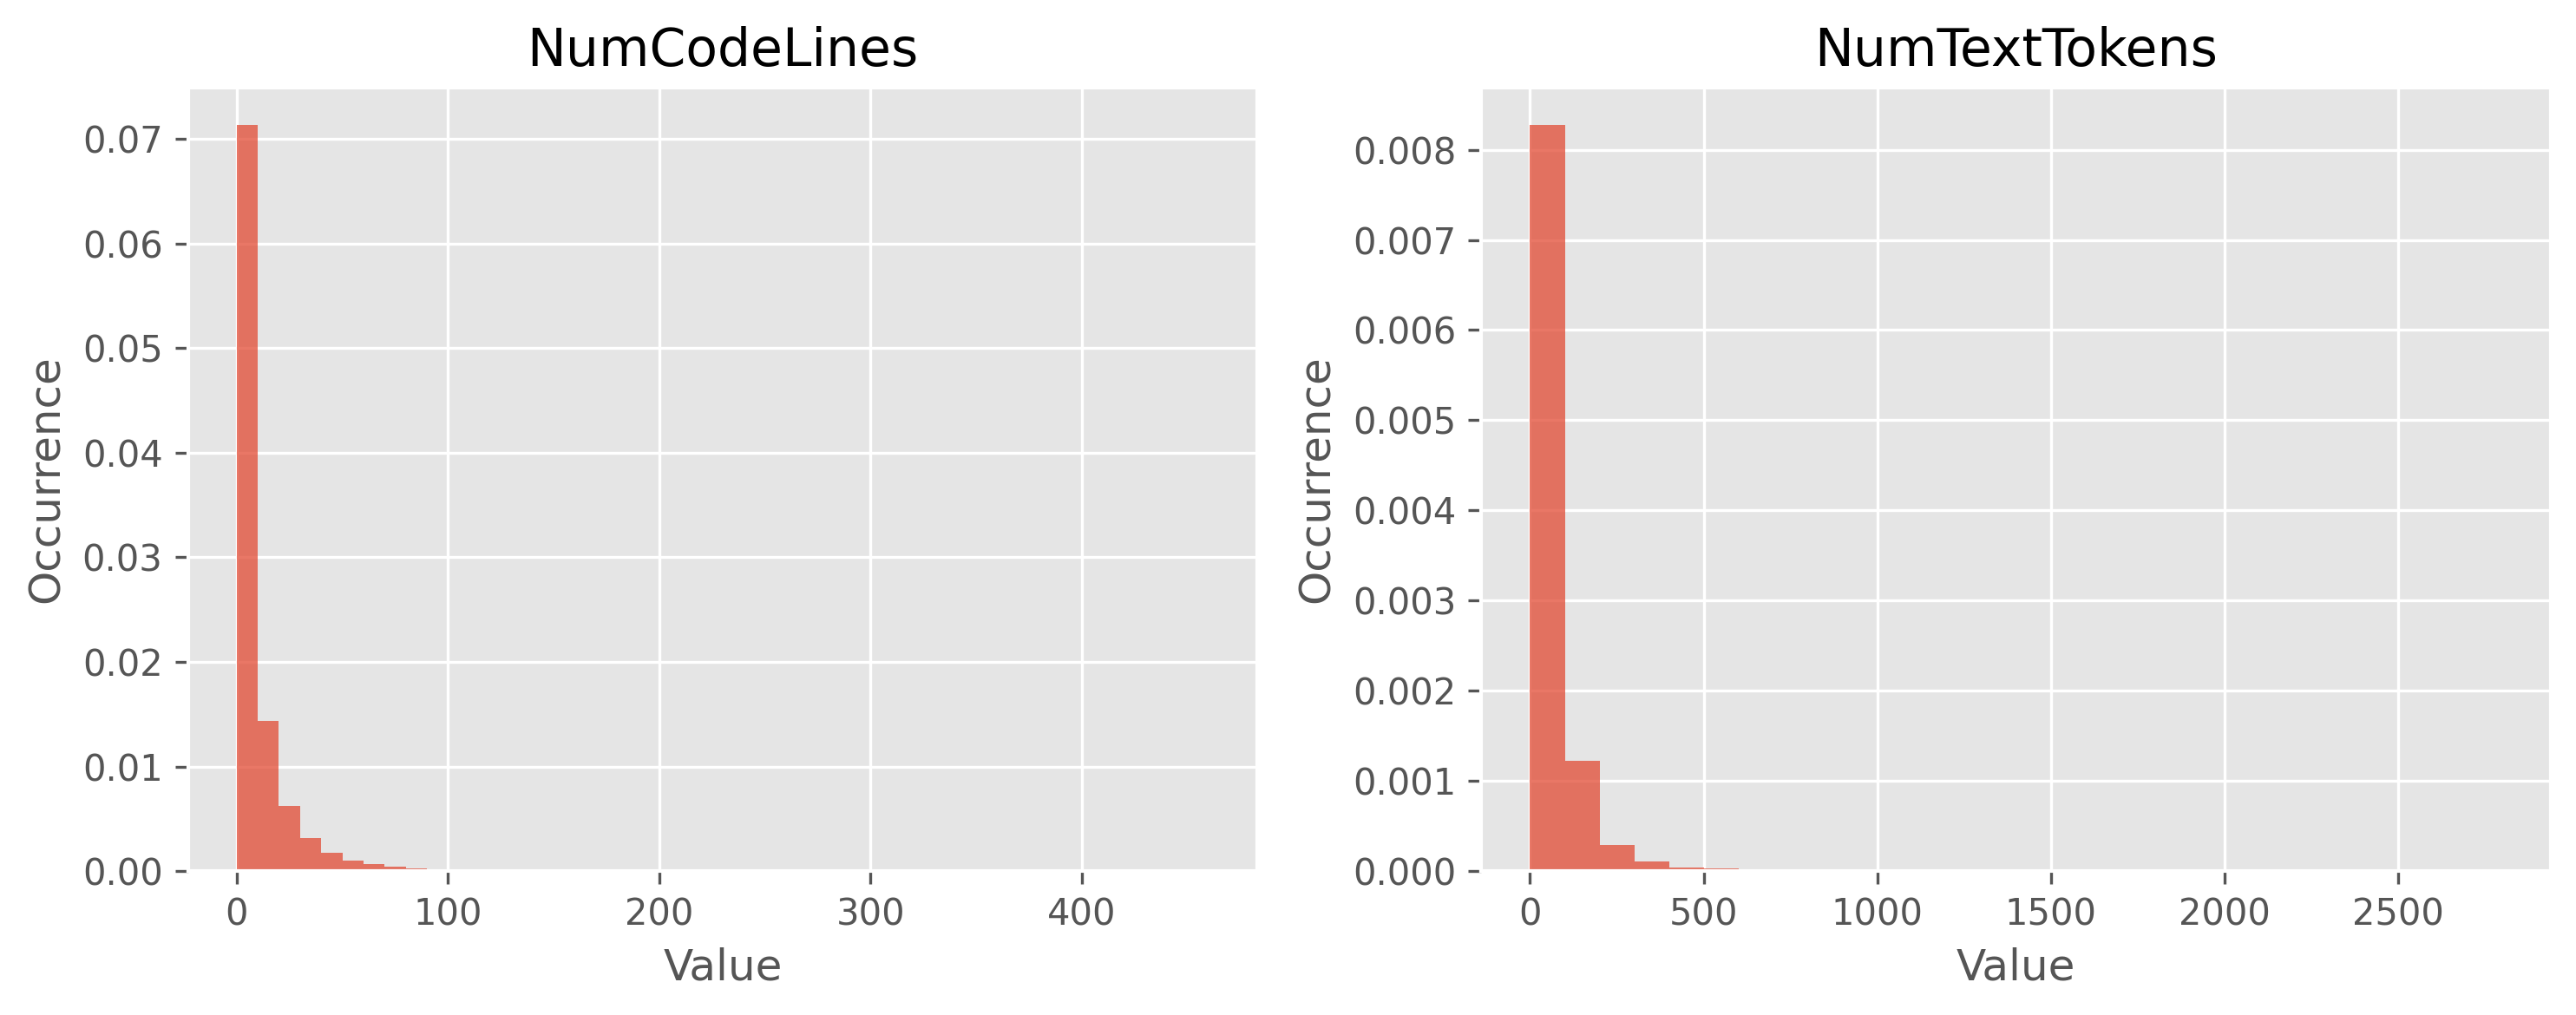

In [14]:
def plot_feat_hist(data_name_list, filename=None):
    if len(data_name_list) > 1:
        assert filename is not None

    num_rows = int(1 + (len(data_name_list) - 1) / 2)
    num_cols = int(1 if len(data_name_list) == 1 else 2)
    plt.figure(figsize=(5 * num_cols, 4 * num_rows), dpi=300)

    for i in range(num_rows):
        for j in range(num_cols):
            plt.subplot(num_rows, num_cols, 1 + i * num_cols + j)
            x, name = data_name_list[i * num_cols + j]
            plt.title(name)
            plt.xlabel('Value')
            plt.ylabel('Occurrence')
            
            max_val = max(x.ravel())
            if max_val>1000:
                bins = range(0, max_val, 100)
            elif max_val>100:
                bins = range(0, max_val, 10)
            else:
                bins = range(0, max_val)
            
            n, bins, patches = plt.hist(x, bins=bins, density=True, stacked=True, alpha=0.75)

            plt.grid(True)
            plt.tight_layout()
    
    if not filename:
        filename = "feat_hist_%s" % name.replace(" ", "_")

    save_png(filename)


plot_feat_hist([(np.asarray([[meta[aid]['NumCodeLines']] for aid in all_answers]), 'NumCodeLines'),
                (np.asarray([[meta[aid]['NumTextTokens']] for aid in all_answers]), 'NumTextTokens')],
              '02_feat_hist_CodeLines_TextTokens');

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def get_features(aid, feature_names):
    return tuple(meta[aid][fn] for fn in feature_names)

X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens']) for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores)))

/var/folders/z3/m6bp6bmn1lj8zyhyktg7y1th0000gn/T/ipykernel_11176/3922577325.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):


  0%|          | 0/10 [00:00<?, ?it/s]

Mean(scores)=0.60605	Stddev(scores)=0.01002


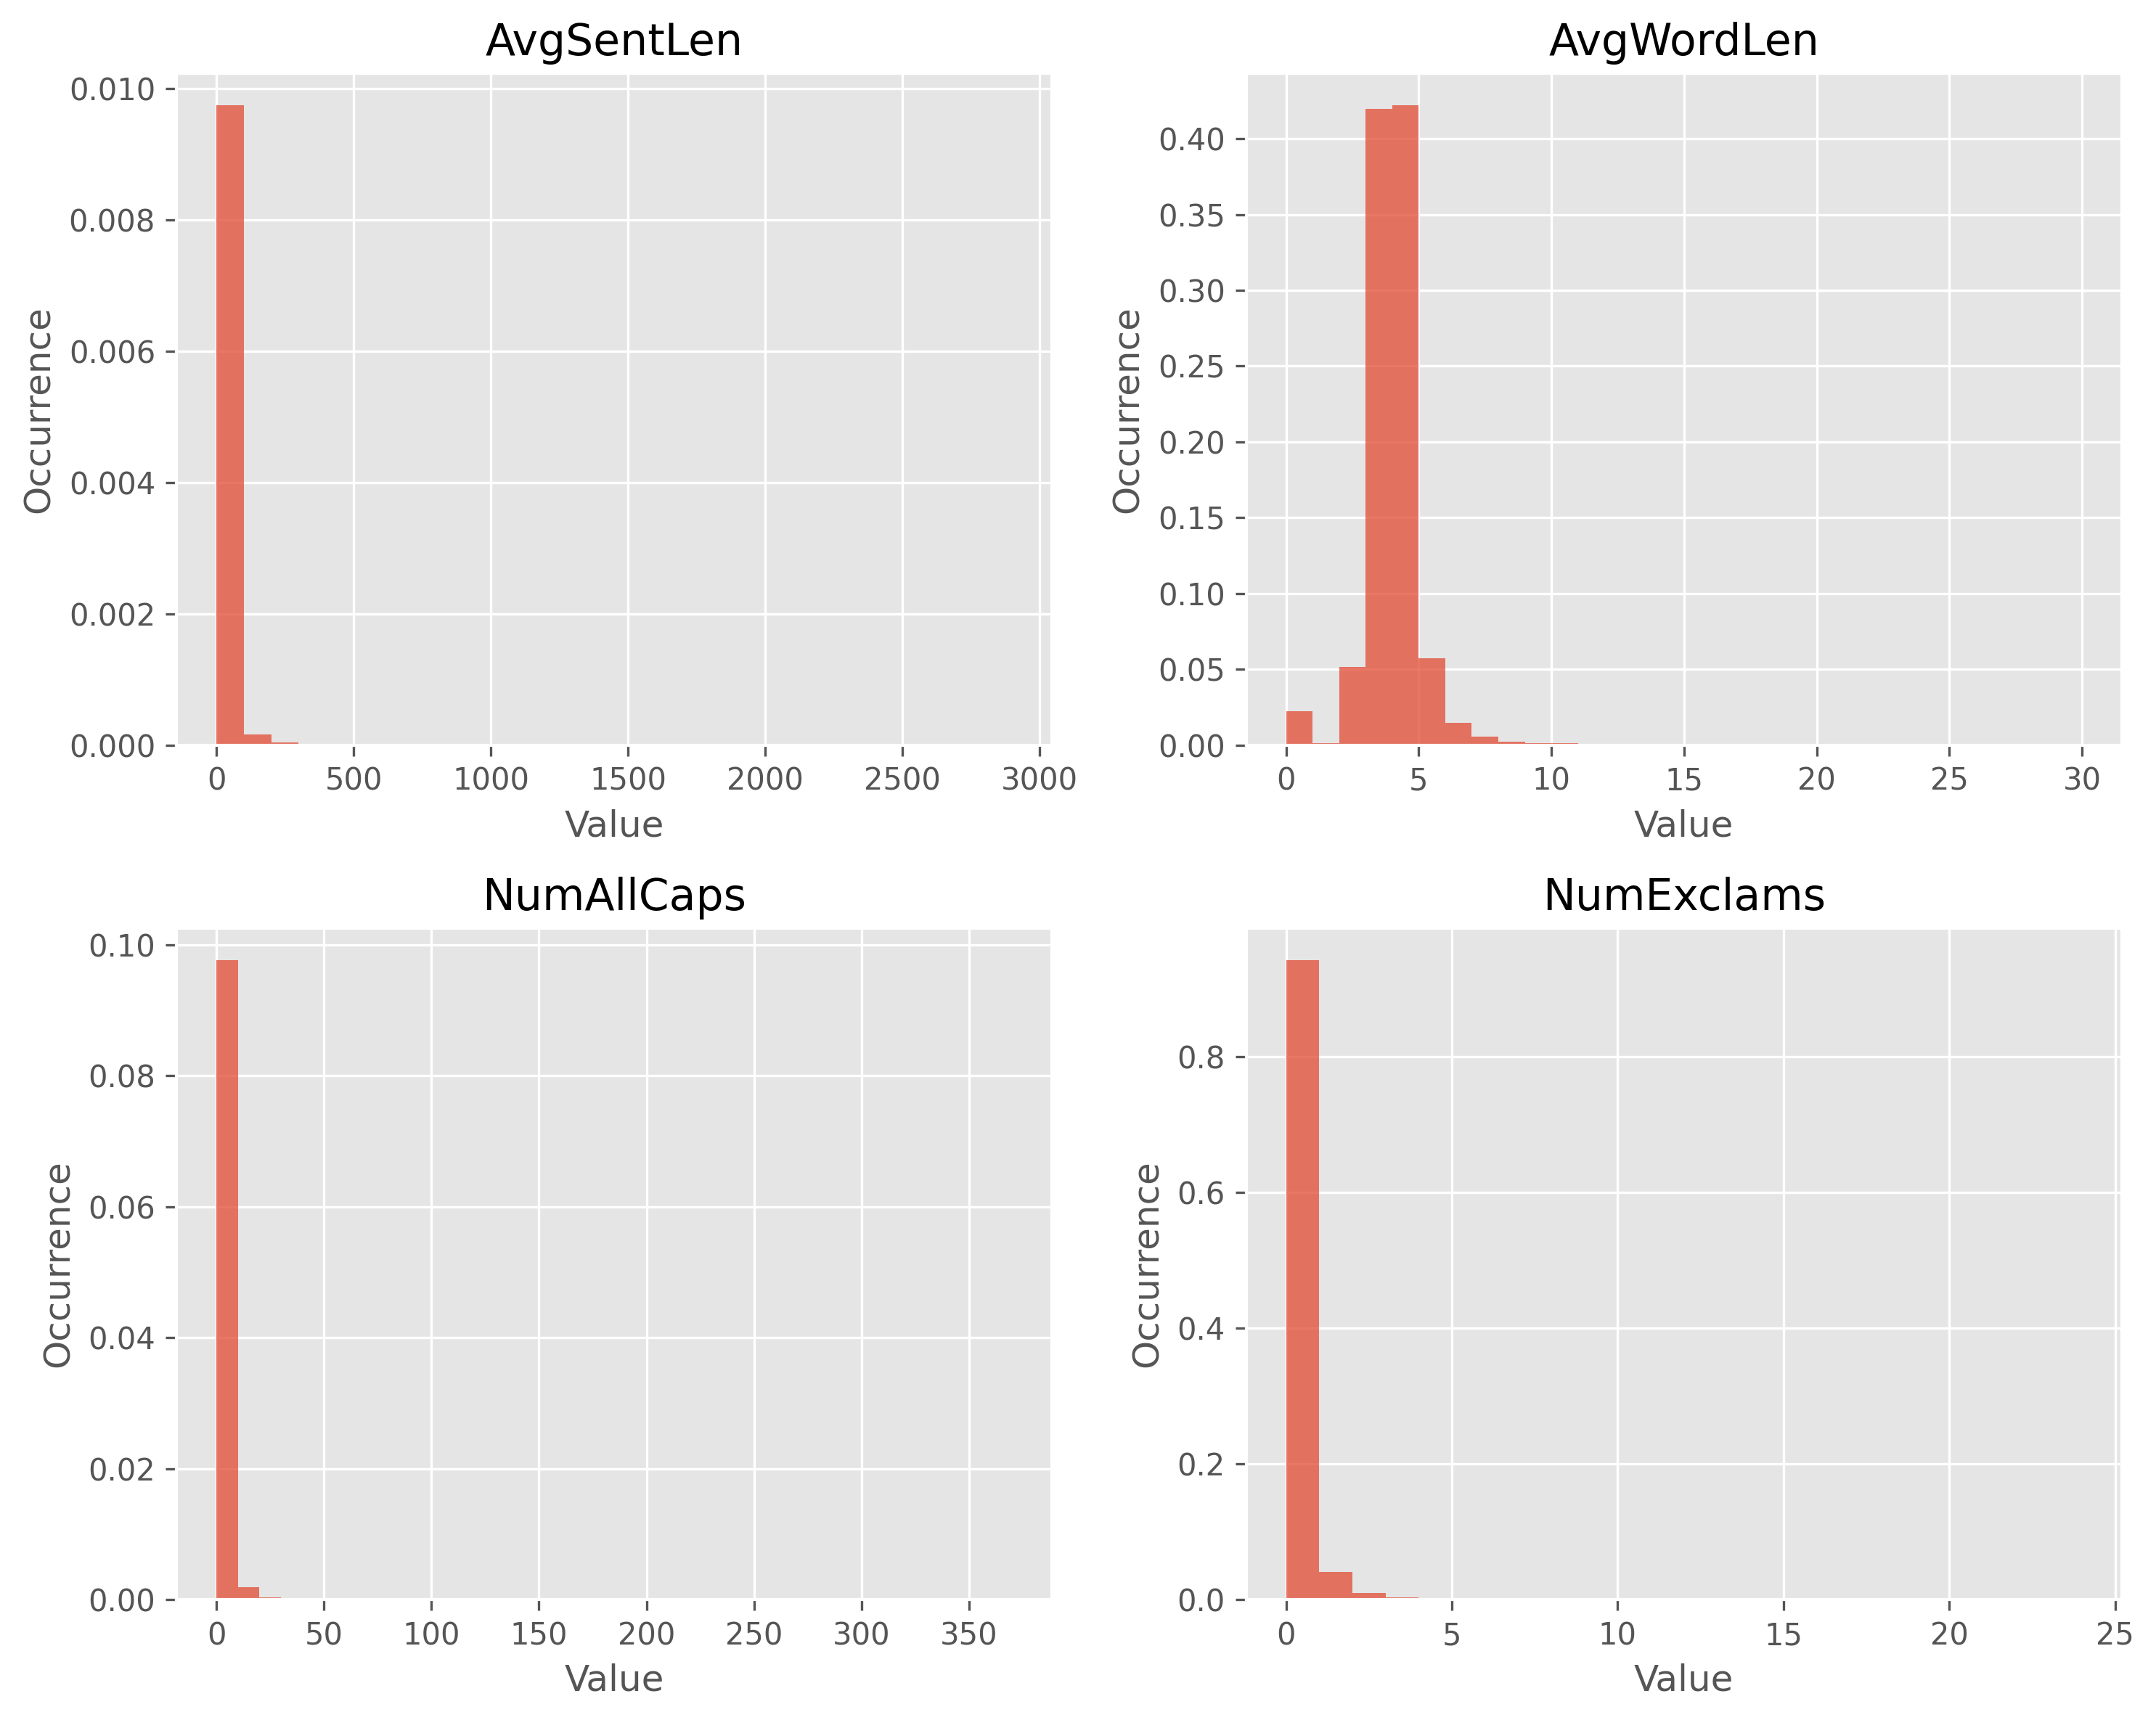

In [16]:
import nltk

def fetch_posts(fn):
    for line in open(fn, 'r', encoding='utf-8'):
        post_id, text = line.split('\t')
        yield int(post_id), text.strip()

def add_sentence_features(m):
    for pid, text in fetch_posts(fn_sample):
        if not text:
            for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']:
                m[pid][feat] = 0
        else:
            sent_lens = [len(nltk.word_tokenize(sent)) for sent in nltk.sent_tokenize(text)]
            m[pid]['AvgSentLen'] = np.mean(sent_lens)
            text_tokens = nltk.word_tokenize(text)
            m[pid]['AvgWordLen'] = np.mean([len(w) for w in text_tokens])
            m[pid]['NumAllCaps'] = np.sum([word.isupper() for word in text_tokens])
            m[pid]['NumExclams'] = text.count('!')

add_sentence_features(meta)

plot_feat_hist([(np.asarray([[meta[aid][feat]] for aid in all_answers], dtype=int), feat) for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']],
              '03_feat_hist_AvgSentLen_AvgWordLen_NumAllCaps_NumExclams');

In [17]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 
                                   'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 
                                   'NumExclams']) for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):    
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 

/var/folders/z3/m6bp6bmn1lj8zyhyktg7y1th0000gn/T/ipykernel_11176/2066044636.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):


  0%|          | 0/10 [00:00<?, ?it/s]

Mean(scores)=0.60440	Stddev(scores)=0.00810


In [18]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report

def plot_bias_variance(data_sizes, train_errors, test_errors, name, title):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('Data set size')
    plt.ylabel('Error')
    plt.title("Bias-Variance for '%s'" % name)
    plt.plot(
        data_sizes, test_errors, "--", data_sizes, train_errors, "b-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)

def plot_pr(auc_score, name, precision, recall, label=None):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))
    plt.fill_between(recall, precision, alpha=0.5)
    plt.grid(True)
    plt.plot(recall, precision, lw=1)
    filename = name.replace(" ", "_")+'_pr'
    save_png(filename)

def plot_feat_importance(feature_names, clf, name):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    coef_ = clf.coef_
    important = np.argsort(np.absolute(coef_.ravel()))
    f_imp = feature_names[important]
    coef = coef_.ravel()[important]
    inds = np.argsort(coef)
    f_imp = f_imp[inds]
    coef = coef[inds]
    xpos = np.array(list(range(len(coef))))
    plt.bar(xpos, coef, width=1, alpha=0.75)

    plt.title('Feature importance for %s' % (name.split('_')[-1]))
    ax = plt.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(f_imp)
    for label in labels:
        label.set_rotation(90)
    filename = name.replace(" ", "_")+'_feat_imp'
    save_png(filename)

def measure(clf_class, parameters, name, X, Y, data_size=None, plot=None, feature_names=None):
    if data_size is not None:
        X = X[:data_size]
        Y = Y[:data_size]

    train_errors = []
    test_errors = []

    scores = []
    roc_scores = []
    fprs, tprs = [], []

    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for fold_idx, (train, test) in enumerate(cv.split(X, Y)):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        only_one_class_in_train = len(set(y_train)) == 1
        only_one_class_in_test = len(set(y_test)) == 1
        if only_one_class_in_train or only_one_class_in_test:
            # this would pose problems later on
            continue

        clf = clf_class(**parameters)

        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        label_idx = 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, proba[:, label_idx])
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, label_idx])

        roc_scores.append(auc(fpr, tpr))
        fprs.append(fpr)
        tprs.append(tpr)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

        threshold_for_detecting_good_answers = 0.59

        if False:
            print("Clone #%i" % fold_idx)
            print(classification_report(y_test, proba[:, label_idx] >
                  threshold_for_detecting_good_answers, target_names=['not accepted', 'accepted']))

    scores_to_sort = pr_scores  
    medium = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]


    if plot:
        plot_pr(pr_scores[medium], name, precisions[medium],
                recalls[medium], plot + " answers")

        if hasattr(clf, 'coef_'):
            plot_feat_importance(feature_names, clf, name)
        elif hasattr(clf, 'named_steps'):
            for step, s_clf in clf.named_steps.items():
                if hasattr(s_clf, 'coef_'):
                    plot_feat_importance(feature_names, s_clf, name)

    summary = {'name': name,
               'scores': scores,
               'roc_scores': roc_scores,
               'pr_scores': pr_scores,
               'med_precisions': precisions[medium], 
               'med_recalls': recalls[medium], 
               'med_thresholds': thresholds[medium]}
    
    return np.mean(train_errors), np.mean(test_errors), summary

def bias_variance_analysis(clf_class, parameters, name, X, Y):
    data_sizes = np.arange(40, 2000, 20)

    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        train_error, test_error, _ = measure(clf_class, parameters, name, X, Y, data_size=data_size)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_bias_variance(data_sizes, train_errors,
                       test_errors, name, "Bias-Variance for '%s'" % name)

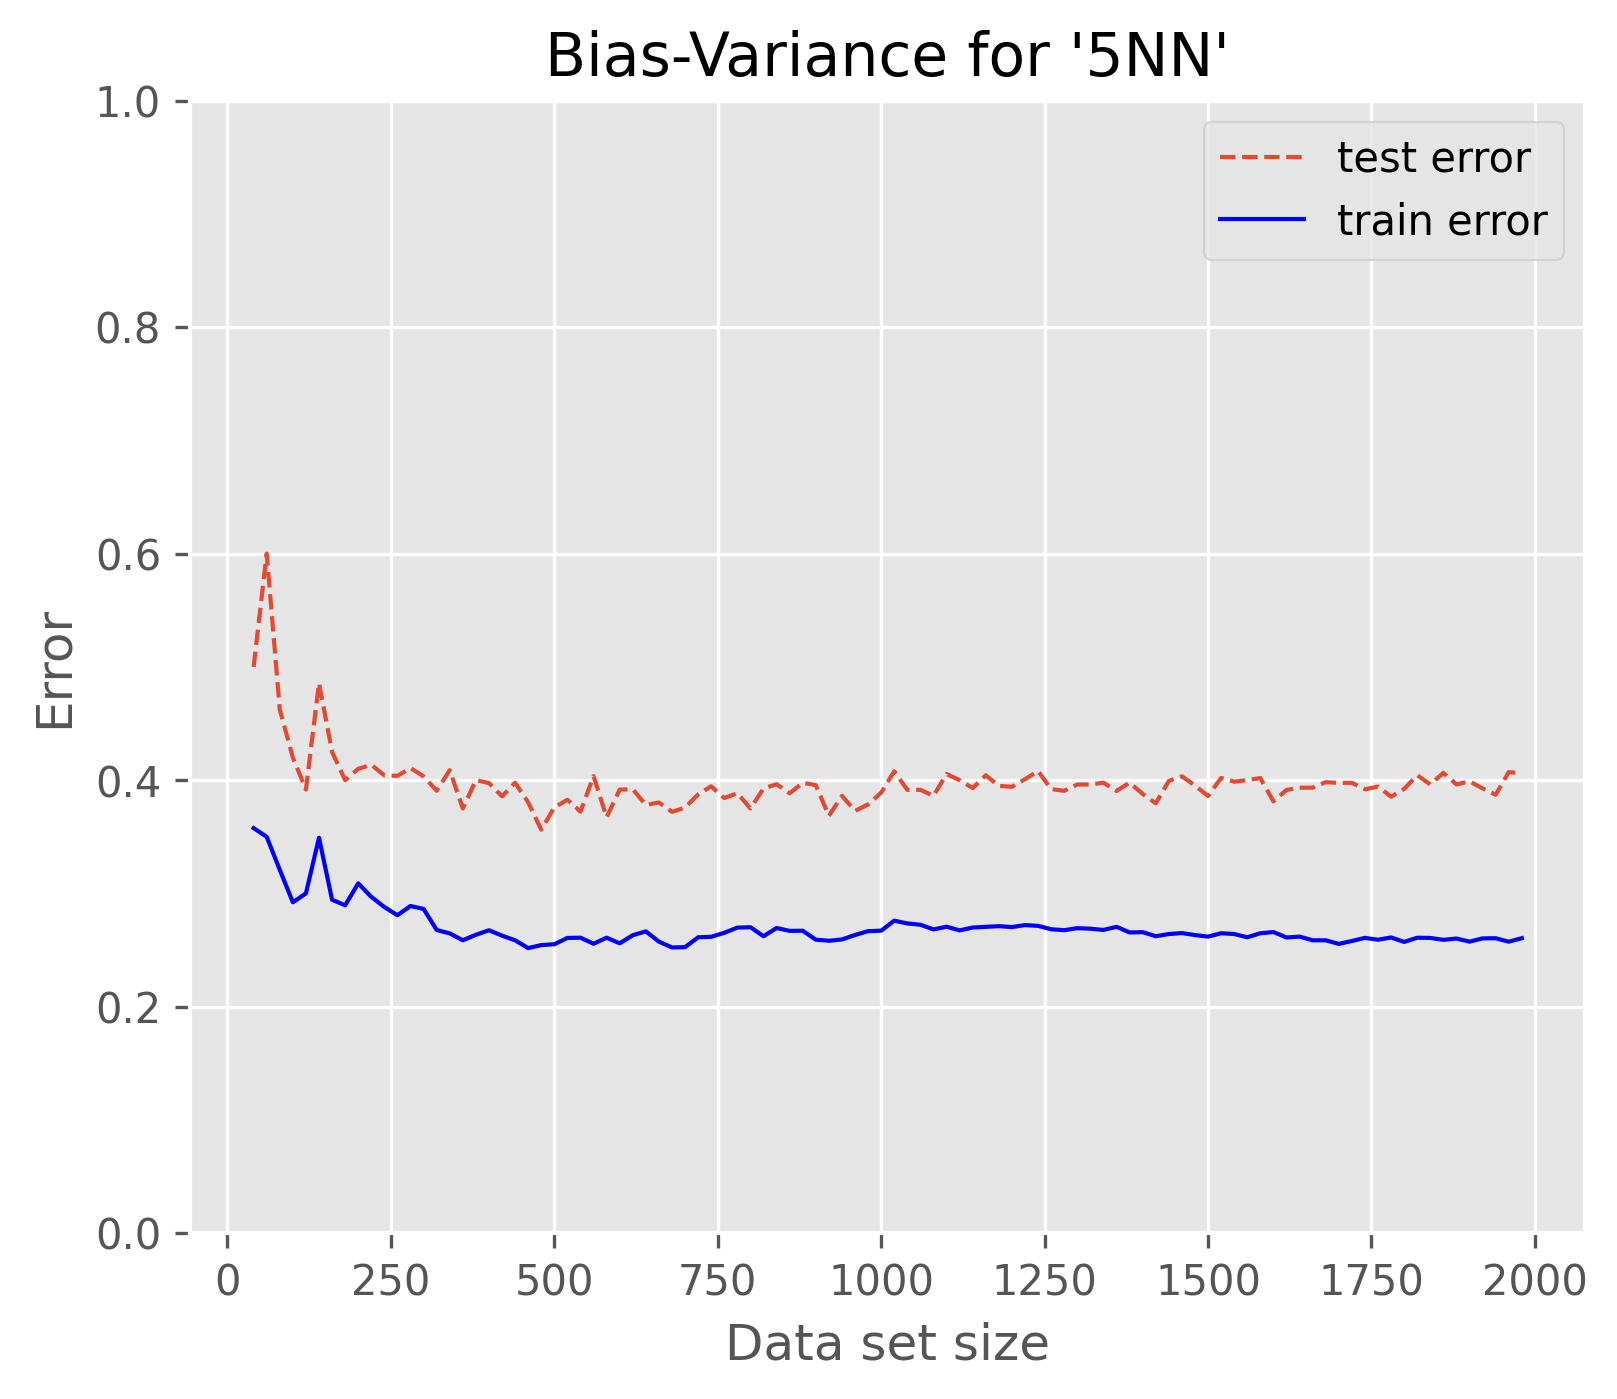

In [19]:
def create_pipeline(**param):
    return make_pipeline(StandardScaler(), KNeighborsClassifier(**param))

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X, Y)
save_png('04_bv_5NN_all')

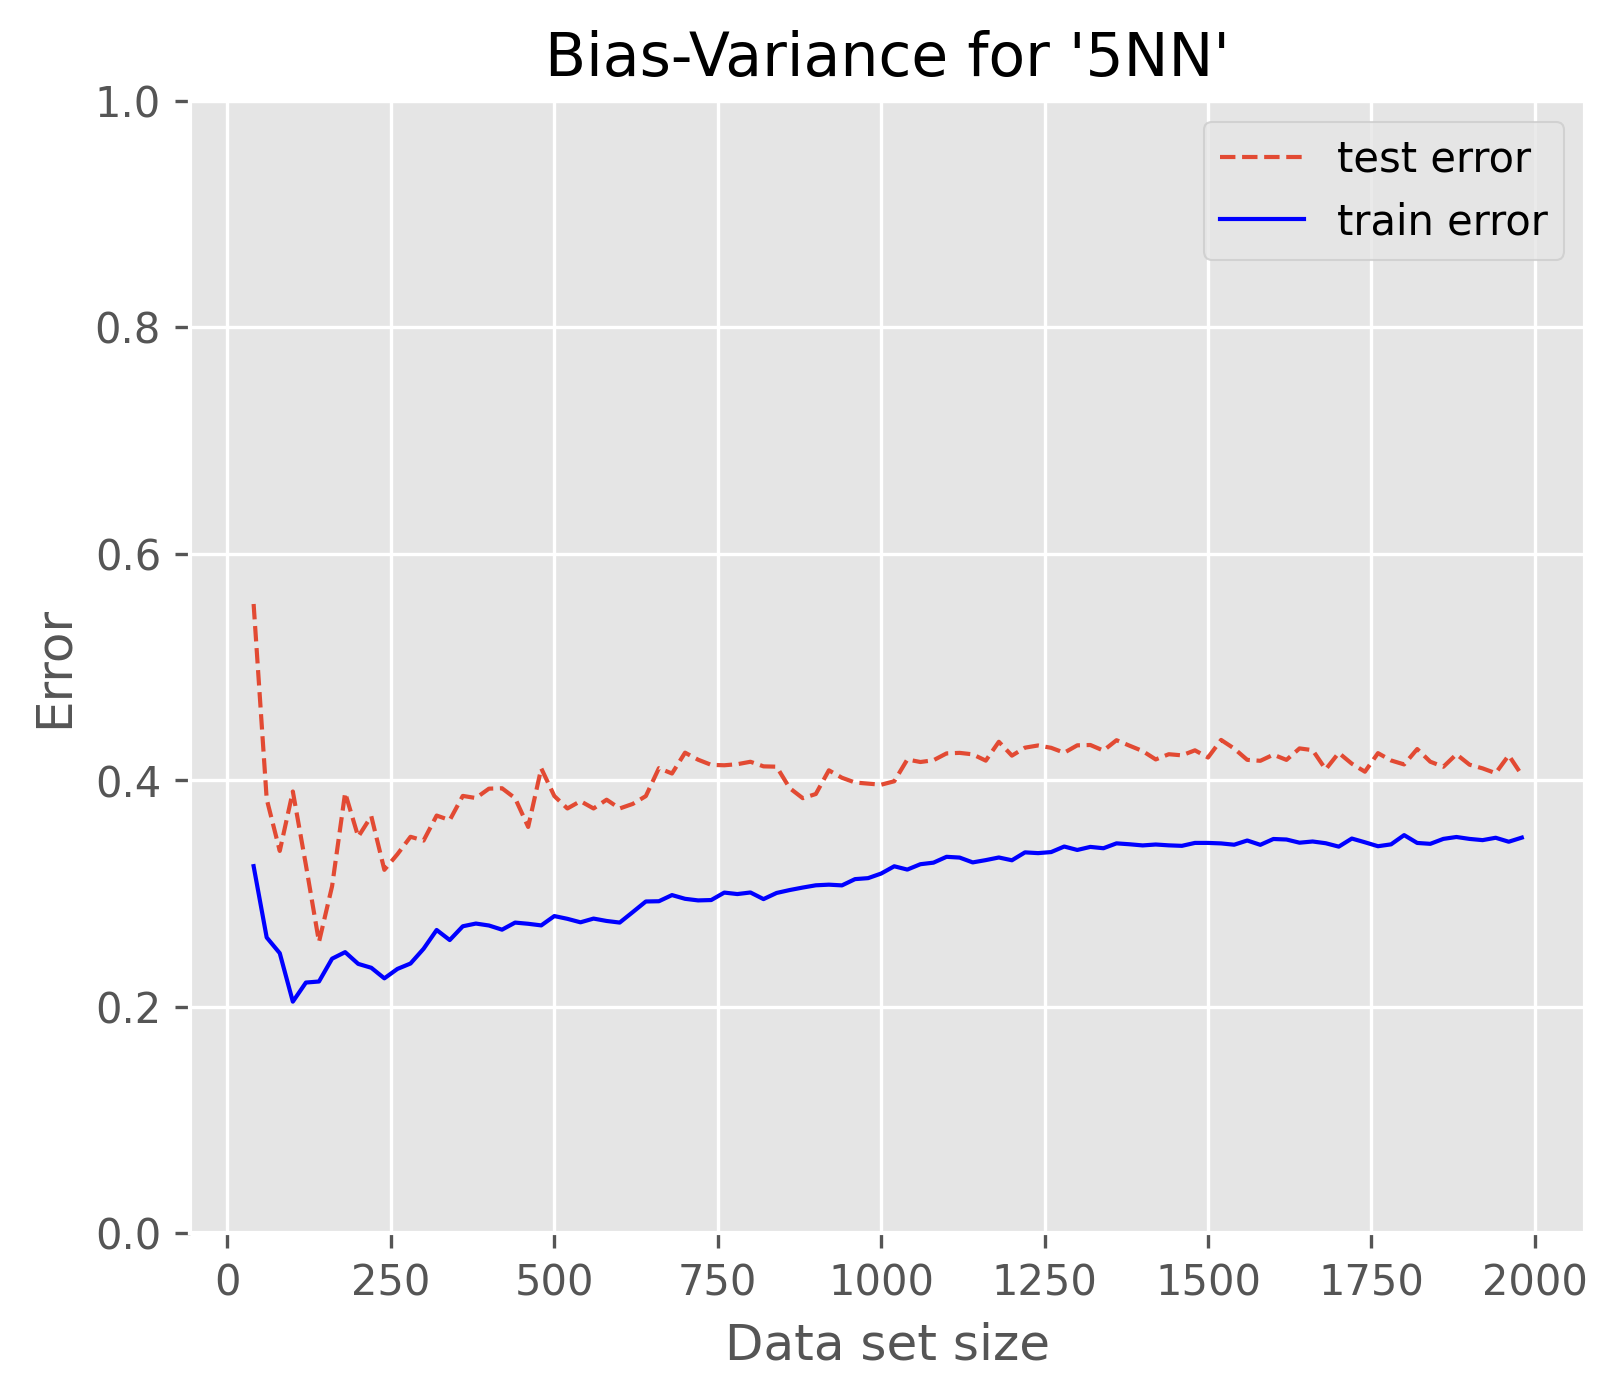

In [20]:
from sklearn.utils import shuffle
X_simp = np.asarray([get_features(aid, ['LinkCount', 'NumTextTokens']) for aid in all_answers], float)
X_simp, Y_simp = shuffle(X_simp, Y, random_state=0)

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X_simp, Y_simp)
save_png('05_bv_5NN_simp')

In [21]:
print('k\tmean(scores)\tstddev(scores)')
for k in [5, 10, 40]:
    _, _, summary = measure(create_pipeline, {'n_neighbors': k}, "%iNN" % k, X, Y)
    print('%d\t%.4f\t\t%.4f' % (k, np.mean(summary['scores']), np.std(summary['scores'])))

k	mean(scores)	stddev(scores)
5	0.6044		0.0081
10	0.6182		0.0108
40	0.6412		0.0106


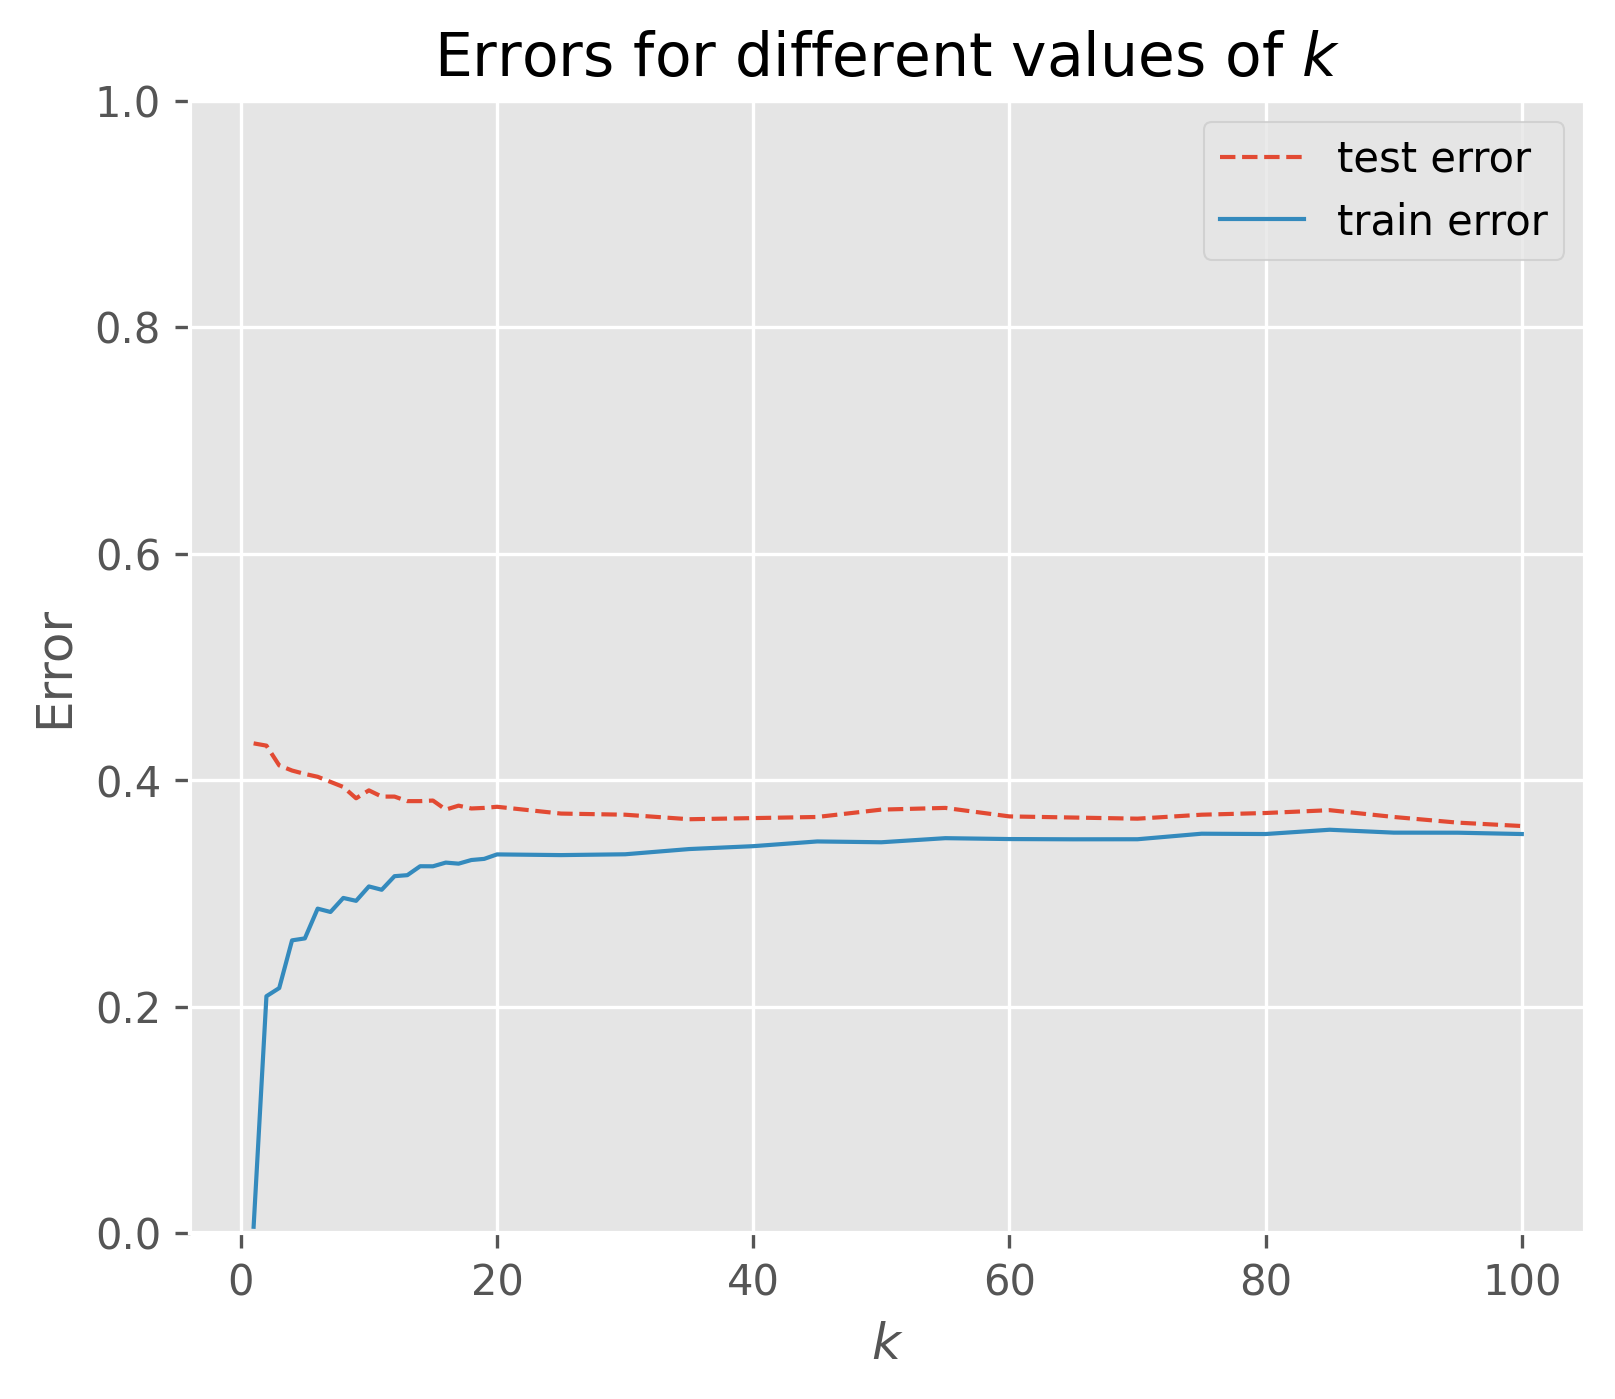

In [22]:
def plot_k_complexity(ks, train_errors, test_errors):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('$k$')
    plt.ylabel('Error')
    plt.title('Errors for different values of $k$')
    plt.plot(ks, test_errors, "--", ks, train_errors, "-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)
    save_png('06_kcomplexity')

def k_complexity_analysis(clf_class, X, Y):
    ks = np.hstack((np.arange(1, 21), np.arange(25, 101, 5)))
    
    train_errors = []
    test_errors = []

    for k in ks:
        train_error, test_error, _ = measure(clf_class, {'n_neighbors': k}, "%dNN" % k, X, Y, data_size=2000)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_k_complexity(ks, train_errors, test_errors)


k_complexity_analysis(create_pipeline, X, Y)    

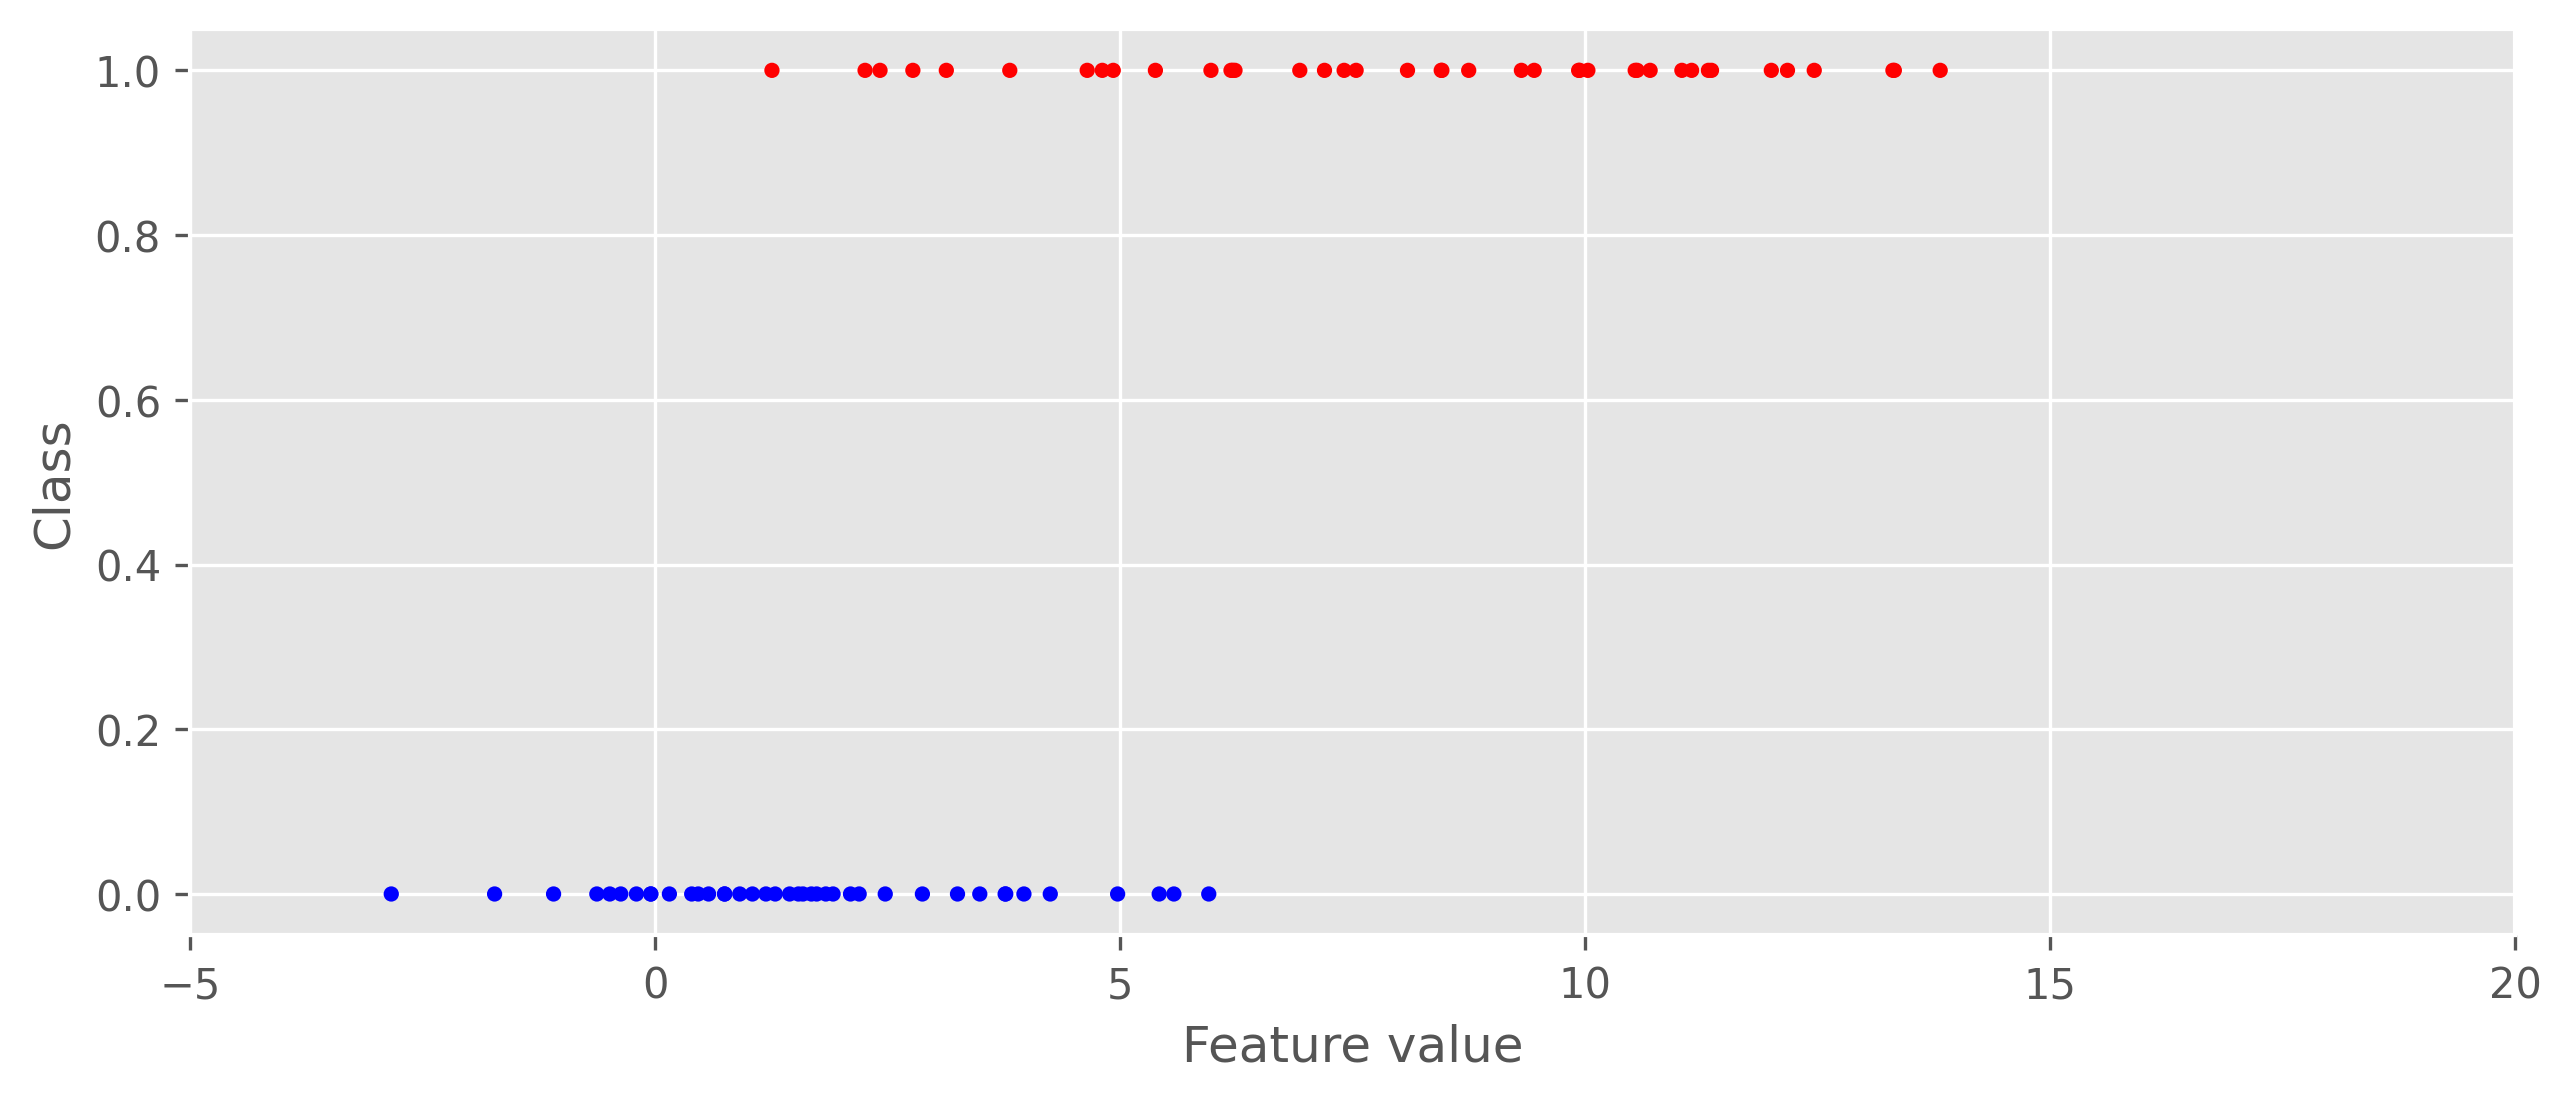

In [23]:
from scipy.stats import norm

np.random.seed(3)

NUM_PER_CLASS = 40
X_log = np.hstack((norm.rvs(2, size=NUM_PER_CLASS, scale=2), norm.rvs(8, size=NUM_PER_CLASS, scale=3)))
y_log = np.hstack((np.zeros(NUM_PER_CLASS), np.ones(NUM_PER_CLASS))).astype(int)

plt.figure(figsize=(10, 4), dpi=300)
plt.grid(True)

plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=10)
plt.xlabel("Feature value")
plt.ylabel("Class")
save_png('06_log_reg_example_data')

In [24]:
from sklearn.linear_model import LogisticRegression

def lr_model(clf, X):
    '''
    https://en.wikipedia.org/wiki/Logistic_regression
    '''
    return 1.0 / (1.0 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

logclf = LogisticRegression()
logclf.fit(X_log.reshape(NUM_PER_CLASS * 2, 1), y_log)
print(np.exp(logclf.intercept_), np.exp(logclf.coef_.ravel()))
print("P(x=-1)=%.2f\tP(x=7)=%.2f" %(lr_model(logclf, -1), lr_model(logclf, 7)))

[0.03518544] [2.17570283]
P(x=-1)=0.02	P(x=7)=0.89


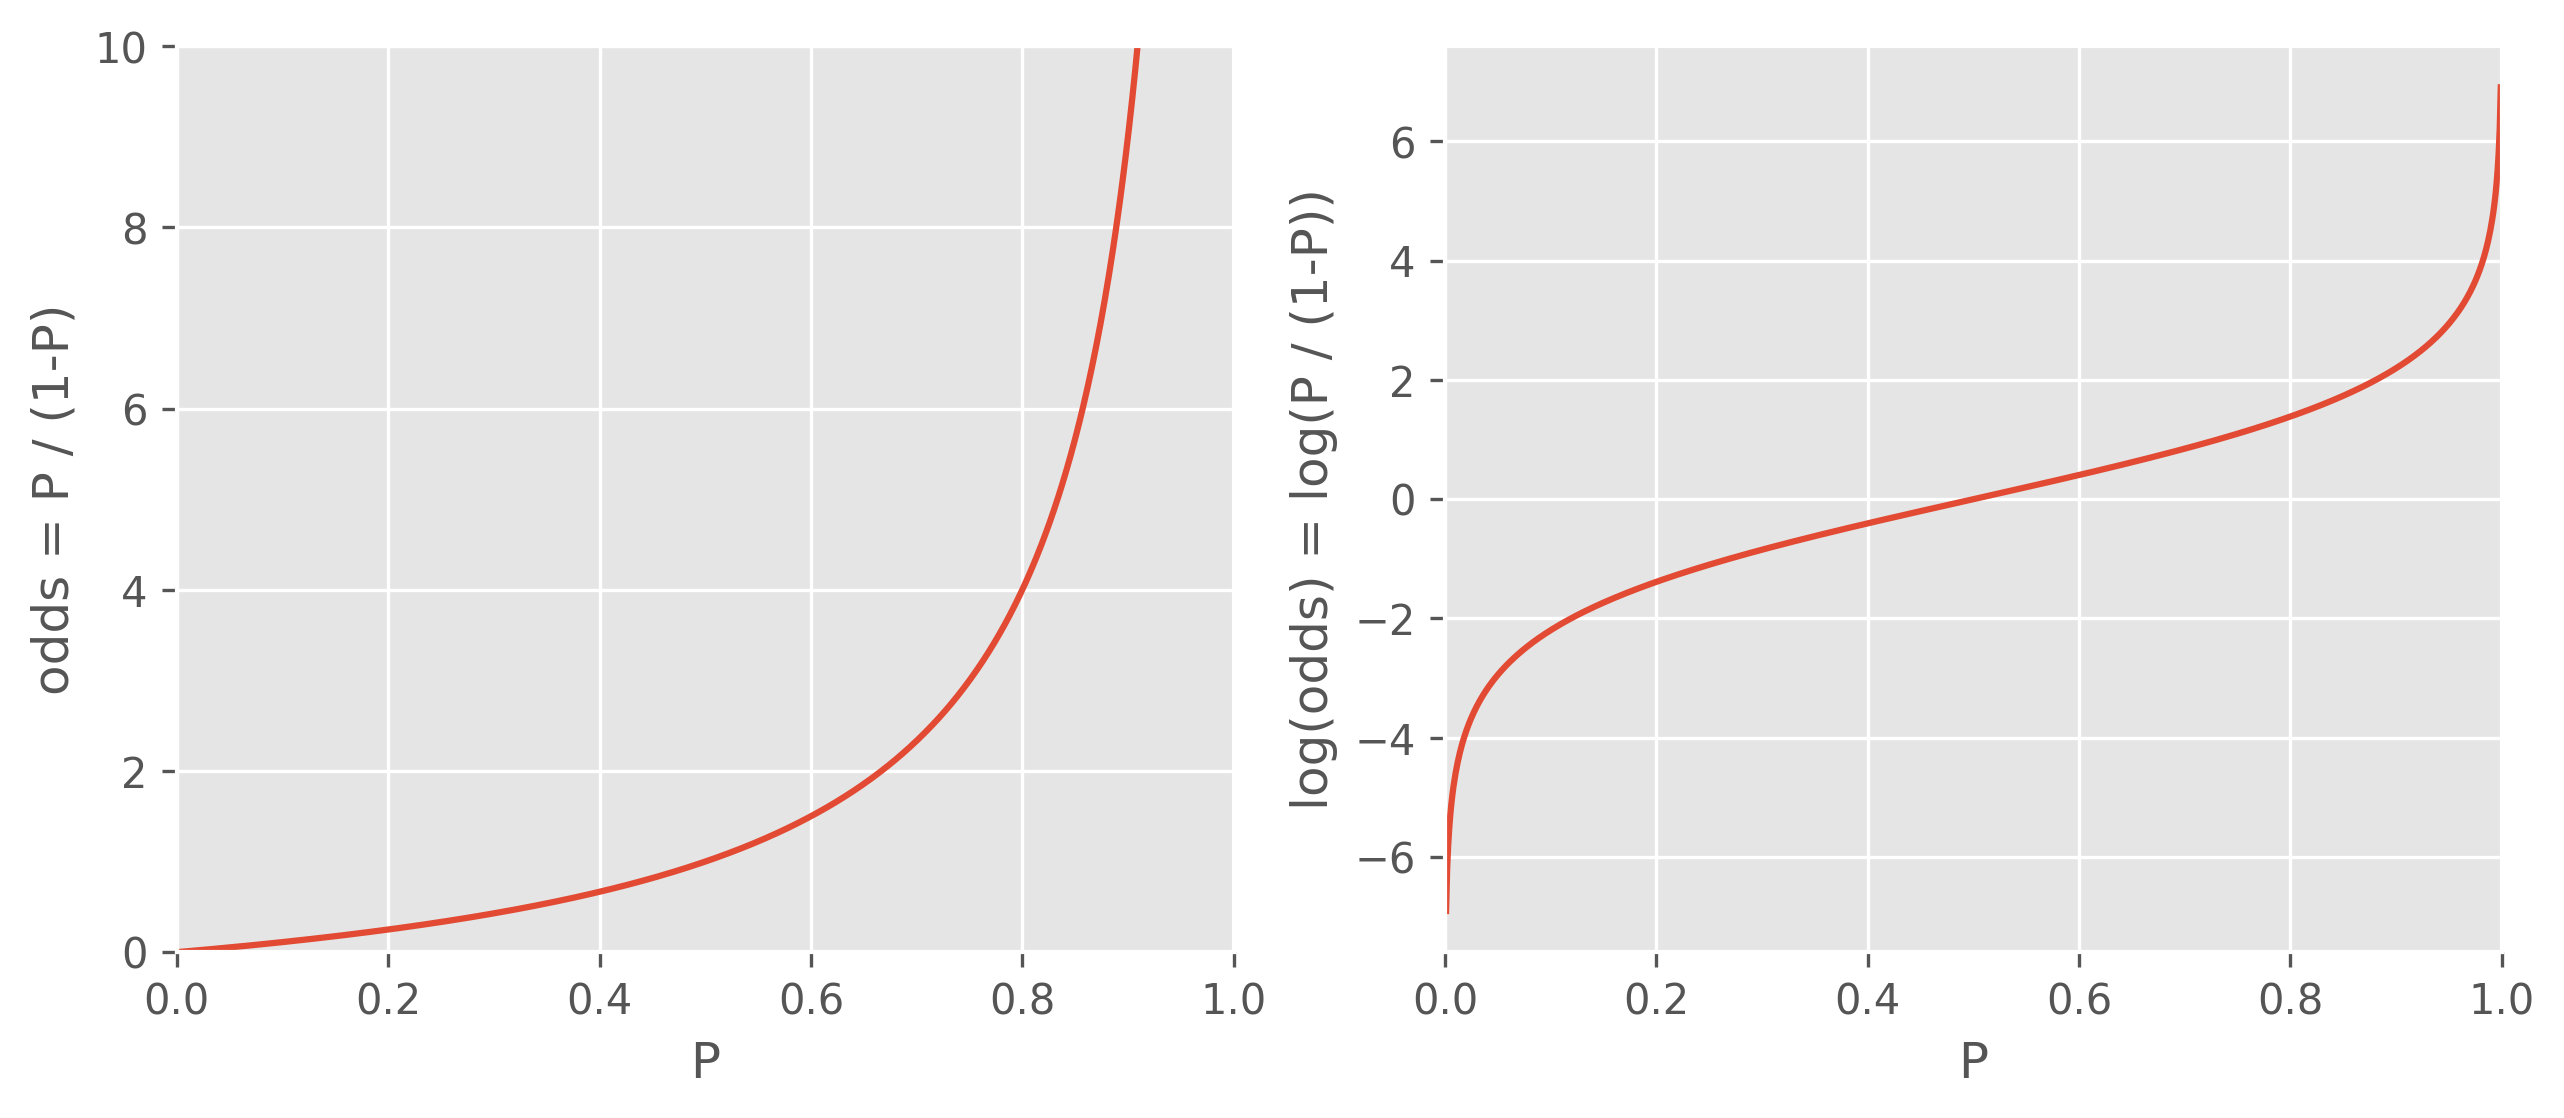

In [25]:
X_odds = np.arange(0.001, 1, 0.001)
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(1, 2, 1)
plt.xlim((0, 1))
plt.ylim((0, 10))
plt.plot(X_odds, X_odds / (1 - X_odds))
plt.xlabel("P")
plt.ylabel("odds = P / (1-P)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlim((0, 1))
plt.plot(X_odds, np.log(X_odds / (1 - X_odds)))
plt.xlabel("P")
plt.ylabel("log(odds) = log(P / (1-P))")
plt.grid(True)
save_png('07_log_reg_log_odds')

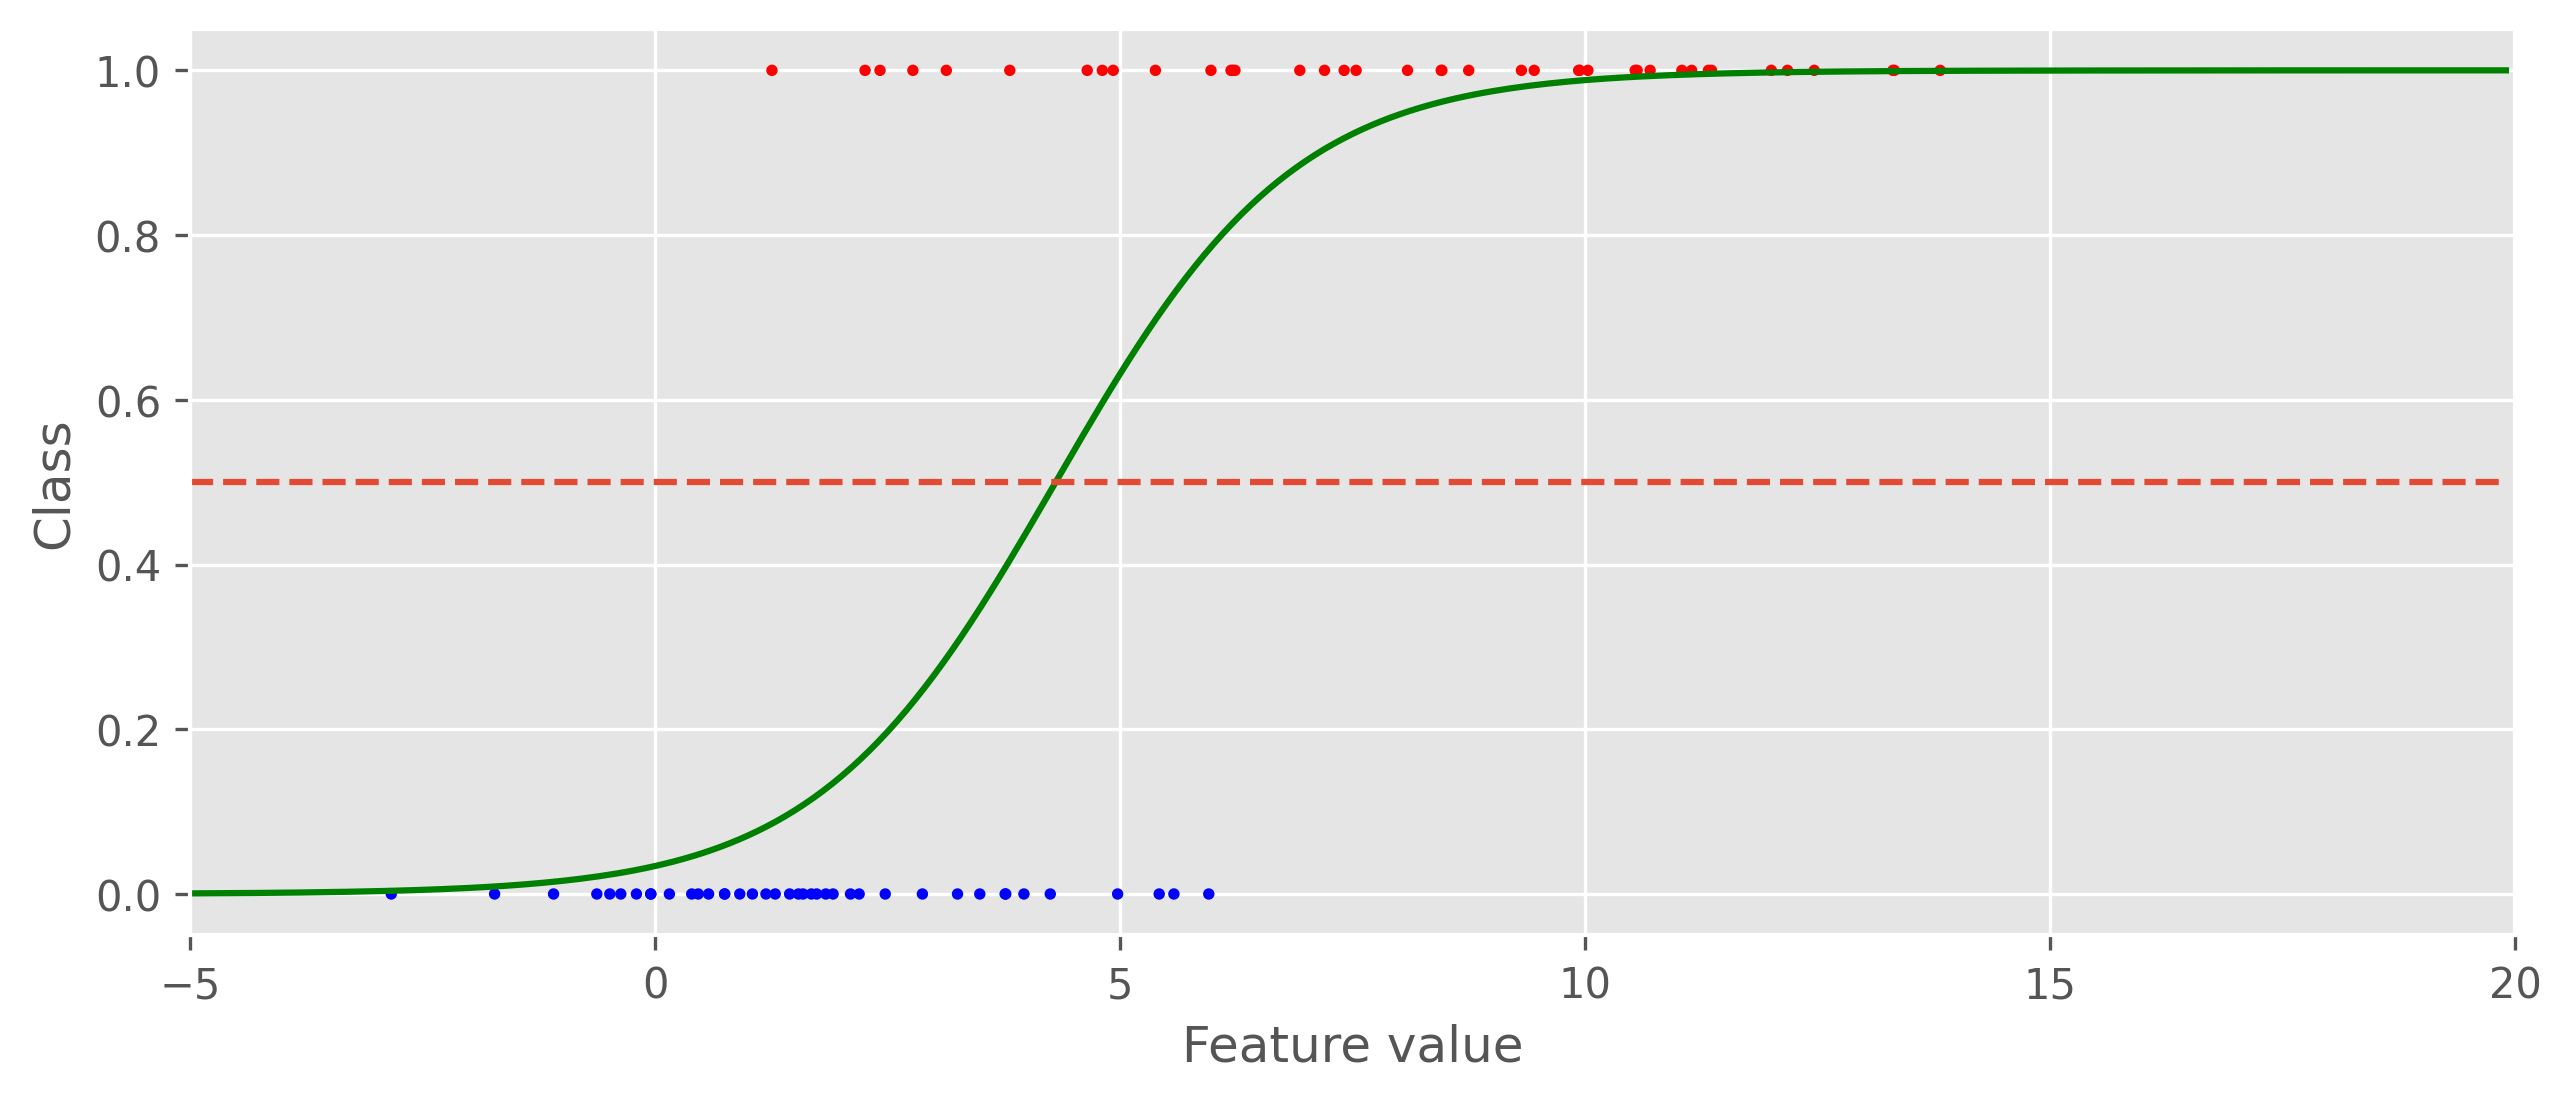

In [26]:
X_range = np.arange(-5, 20, 0.1)

plt.figure(figsize=(10, 4), dpi=300)
plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=5)
plt.plot(X_range, lr_model(logclf, X_range).ravel(), c='green')
plt.plot(X_range, np.ones(X_range.shape[0]) * 0.5, "--")
plt.xlabel("Feature value")
plt.ylabel("Class")
plt.grid(True)
save_png('08_log_reg_example_fitted')

In [27]:
print('C\tmean(scores)\tstddev(scores)') 
for C in [0.001, 0.01, 0.1, 1.0, 10.0]:
    name = "LogReg C=%.2f" % C
    _, _, summary = measure(LogisticRegression, {'C': C}, name, X, Y)

    print('%7.3f\t%.4f\t\t%.4f' % (C, np.mean(summary['scores']), np.std(summary['scores'])))

C	mean(scores)	stddev(scores)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

  0.001	0.6400		0.0091
  0.010	0.6391		0.0087


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

  0.100	0.6385		0.0085


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  1.000	0.6381		0.0087
 10.000	0.6382		0.0087


In [28]:
C_best = 0.01

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

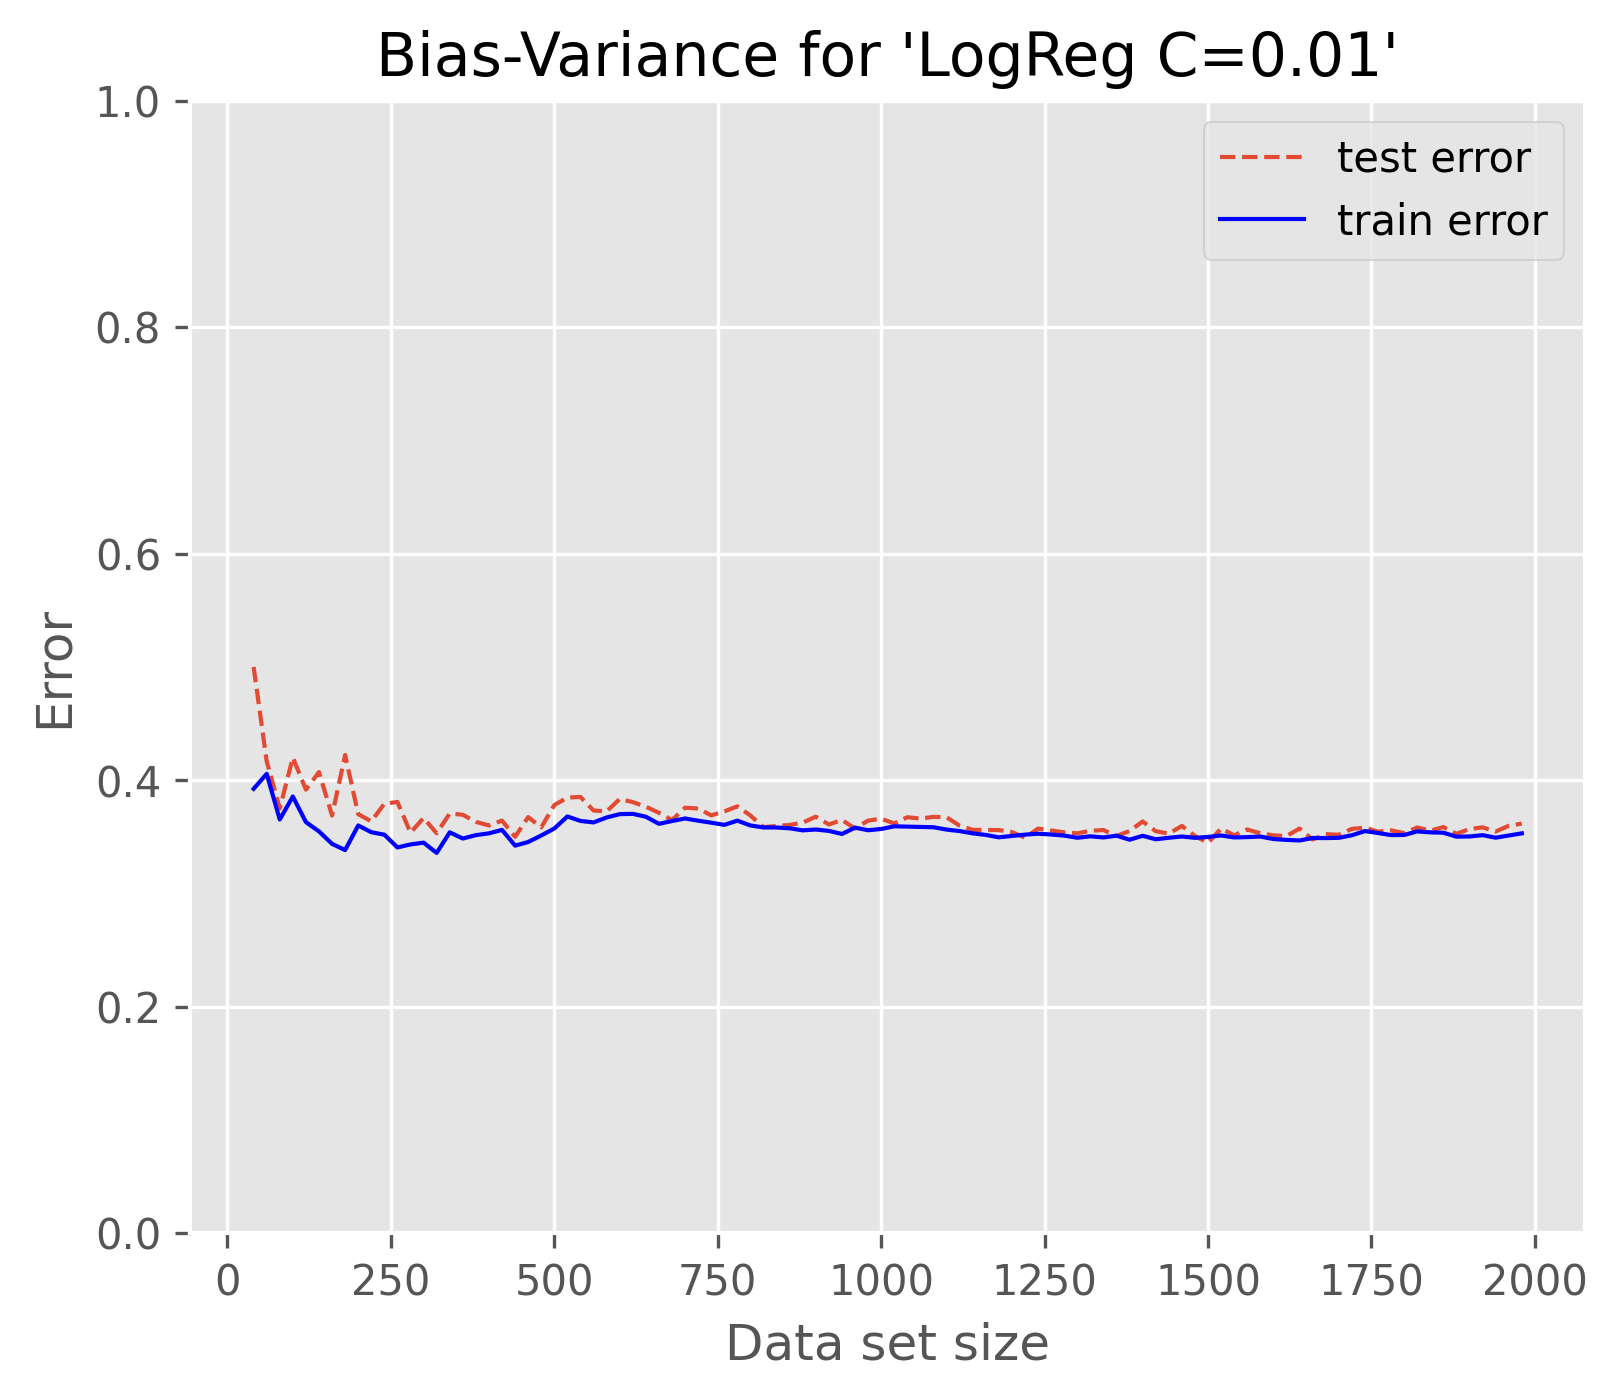

In [29]:
bias_variance_analysis(LogisticRegression, {'C': C_best}, "LogReg C=0.01", X, Y)
save_png('09_bv_LogReg')

Good answers...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

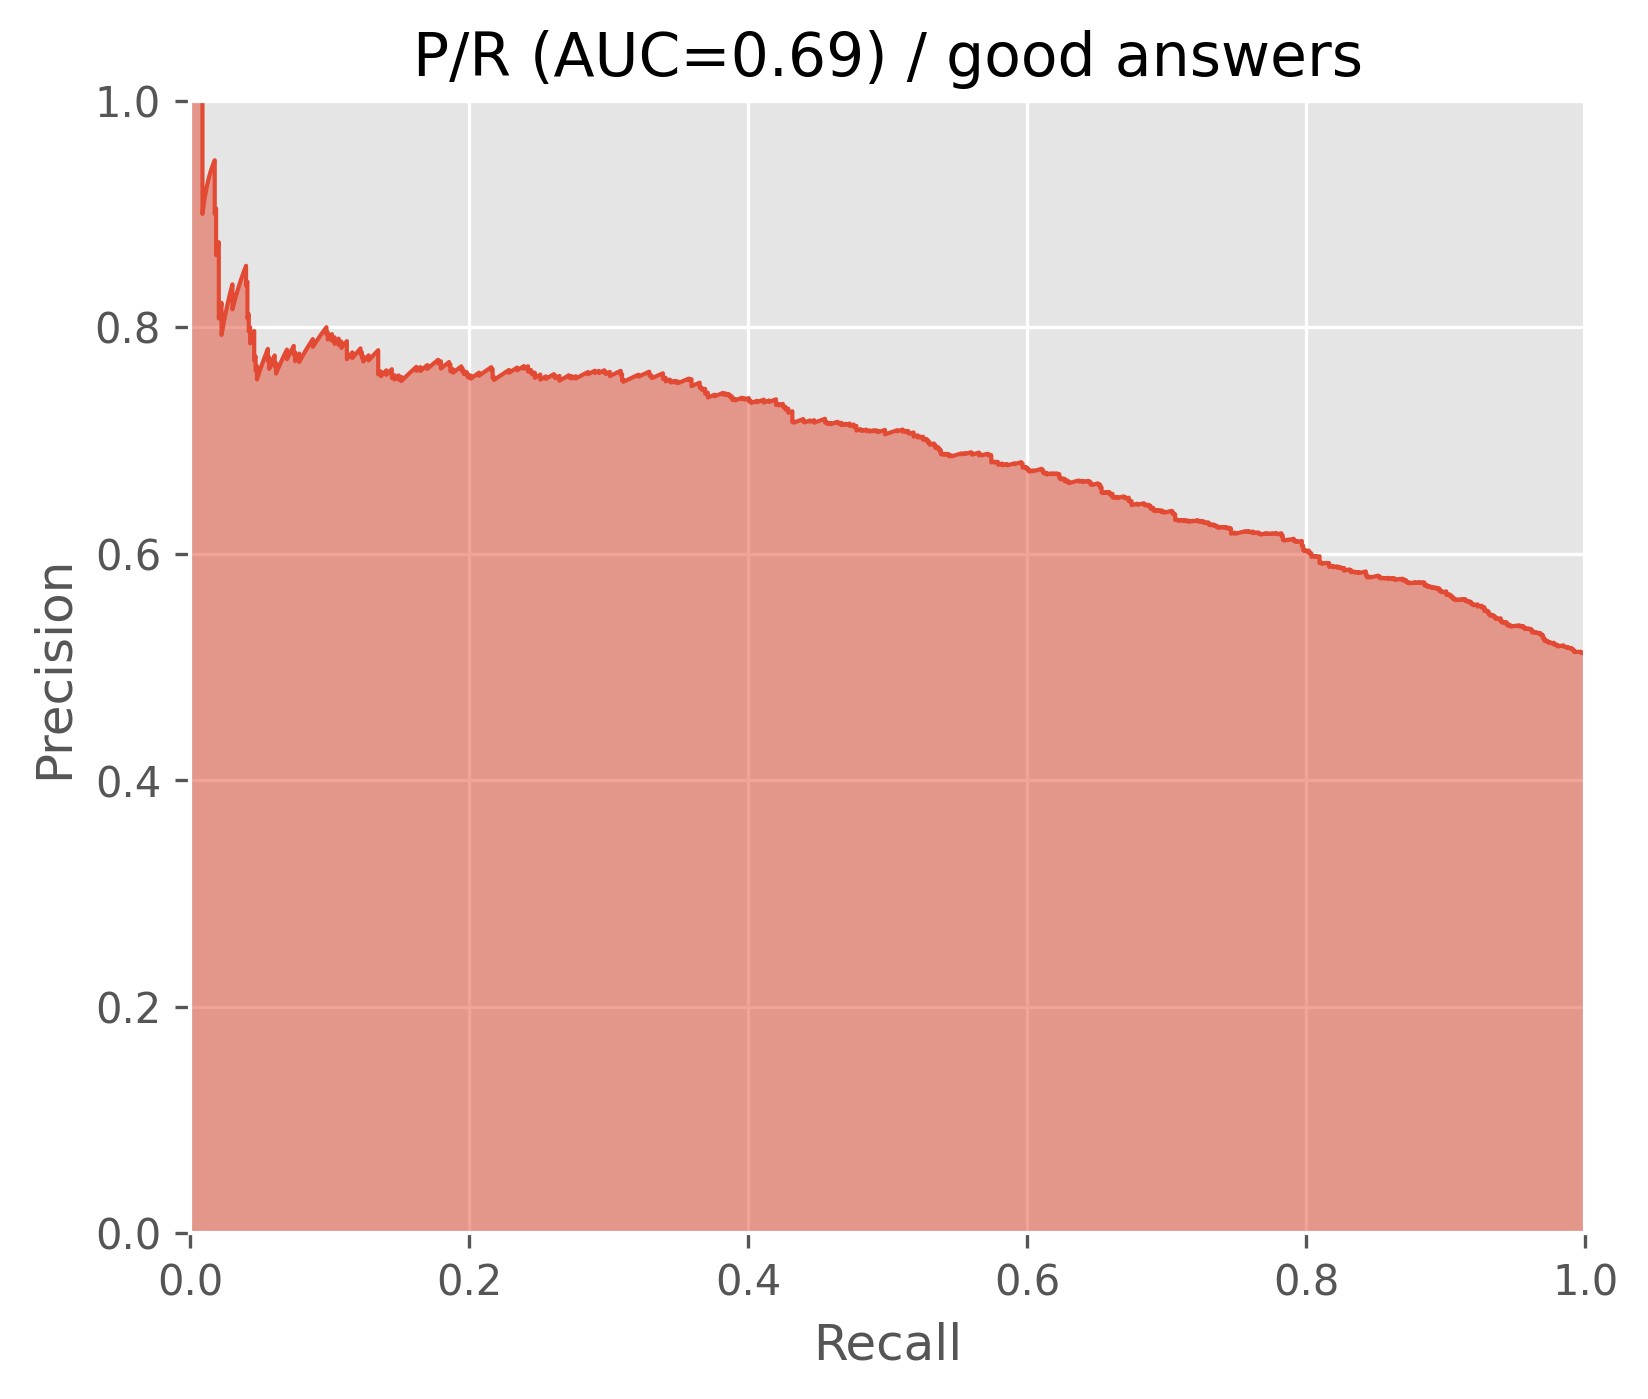

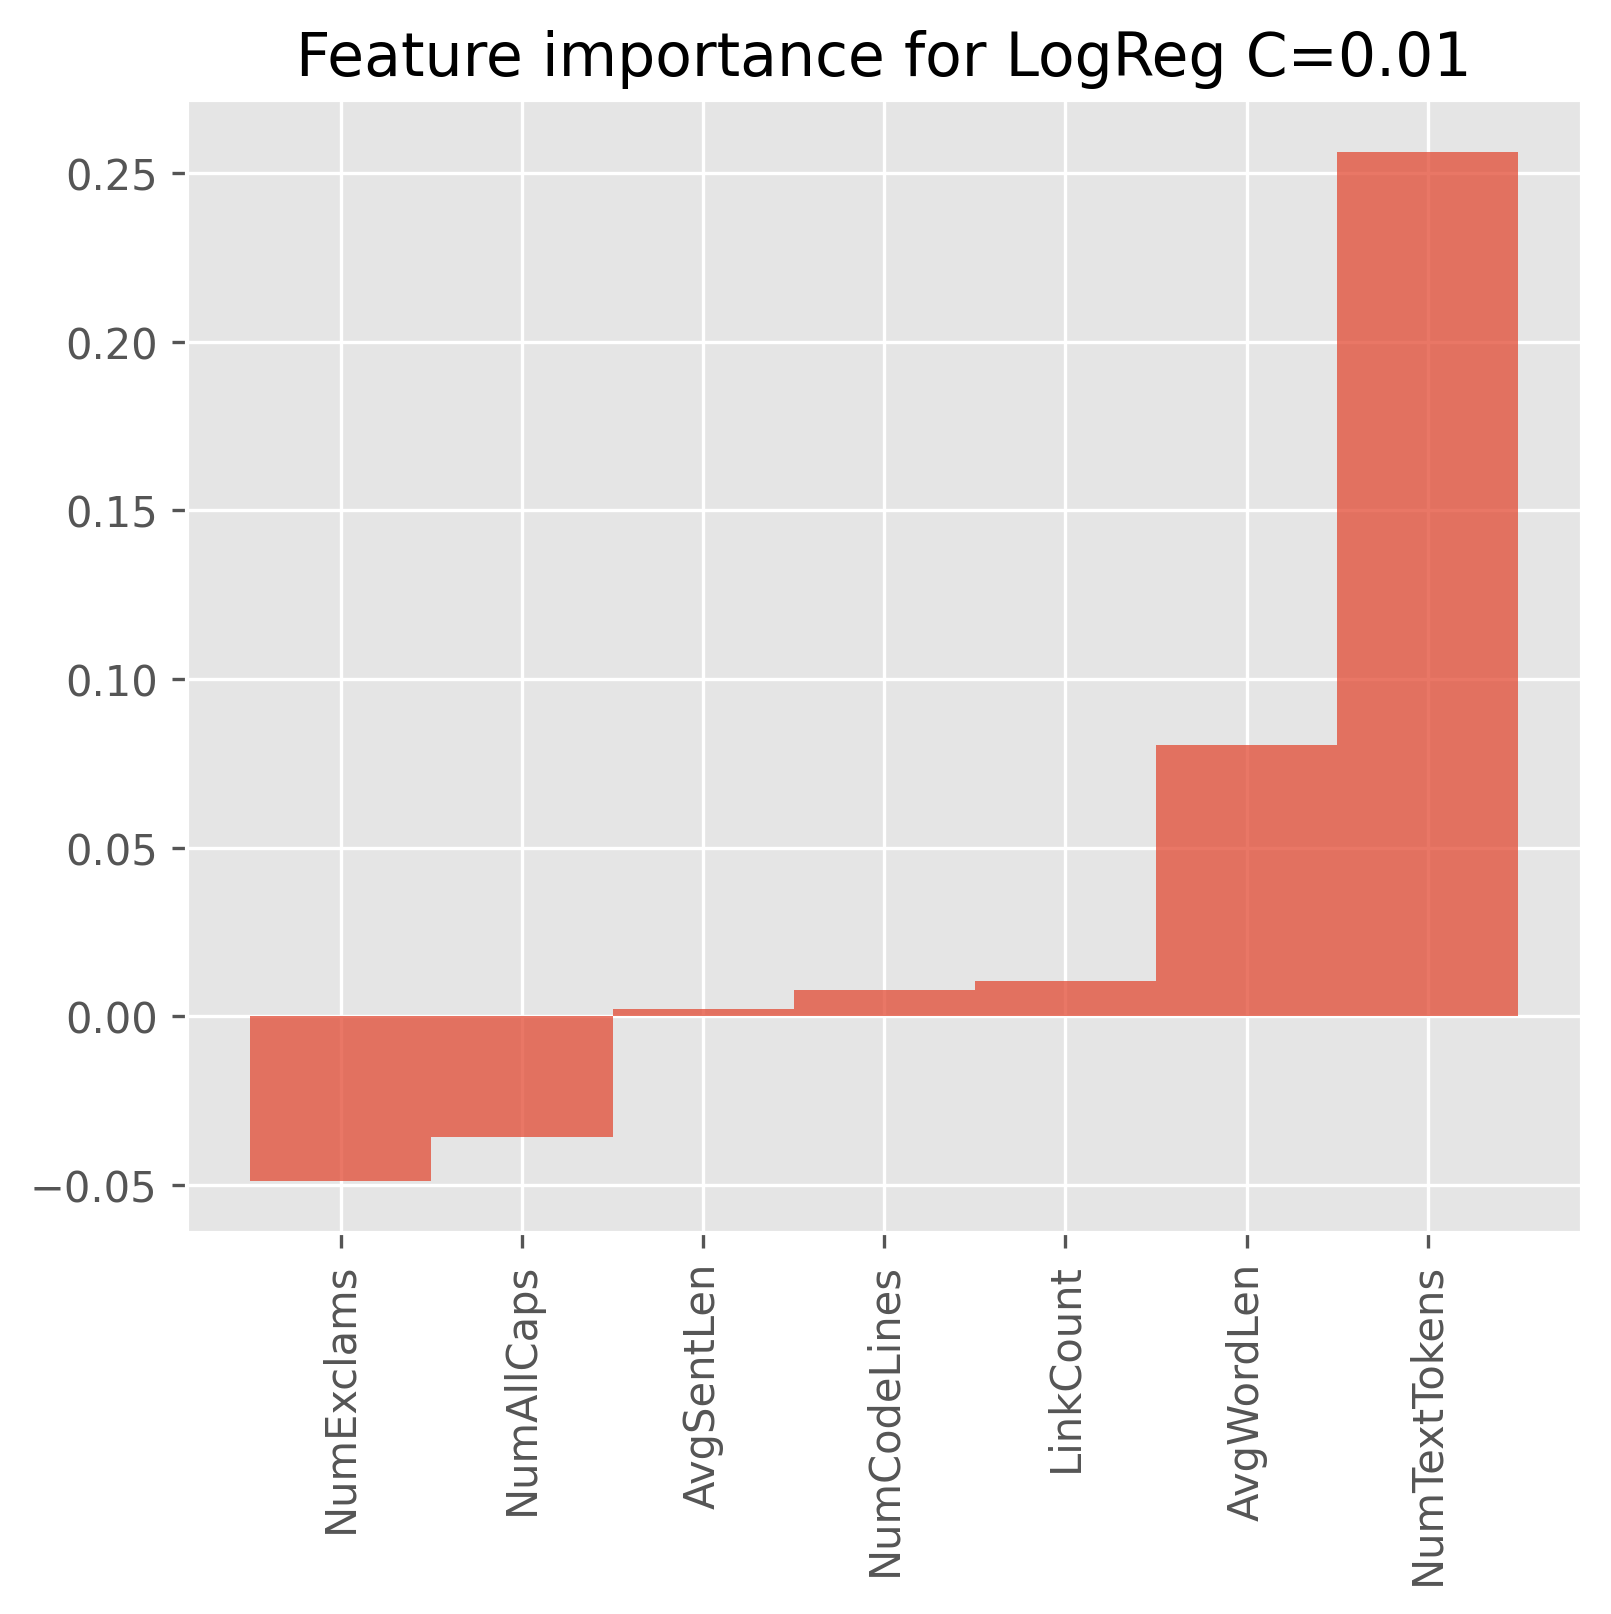

In [30]:
feature_names = np.array((
    'NumTextTokens',
    'NumCodeLines',
    'LinkCount',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams'
))

X_orig = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers])

Y_orig_good = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
Y_orig_poor = np.asarray([meta[aid]['Score'] <= 0 for aid in all_answers])

X_new, Y_good, Y_poor = shuffle(X_orig, Y_orig_good, Y_orig_poor, random_state=0)
    
name = "LogReg C=%.2f" % C_best

print("Good answers...")
_, _, good_results = measure(LogisticRegression, {'C': C_best}, '08_good_'+name, X_new, Y_good, plot='good', feature_names=feature_names)

Poor answers...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

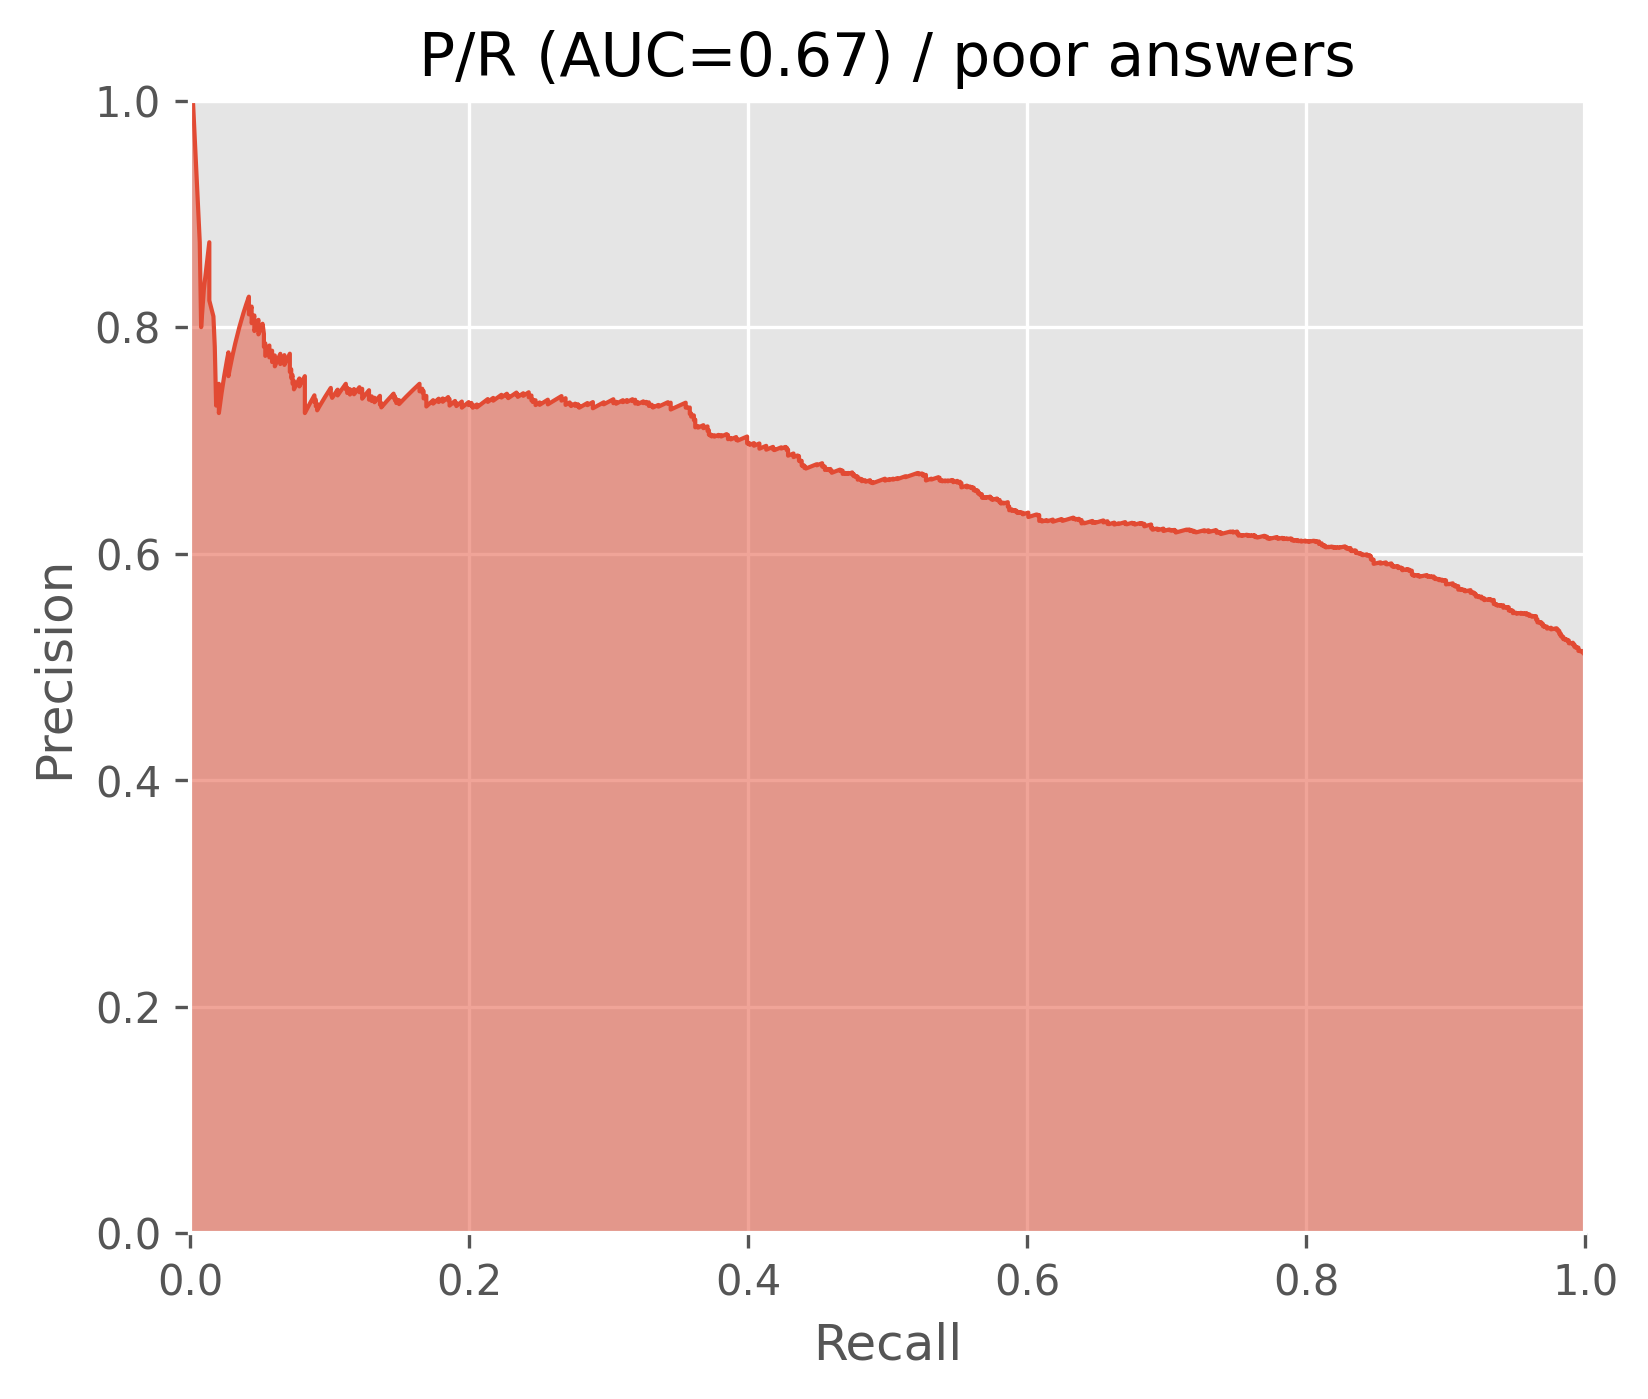

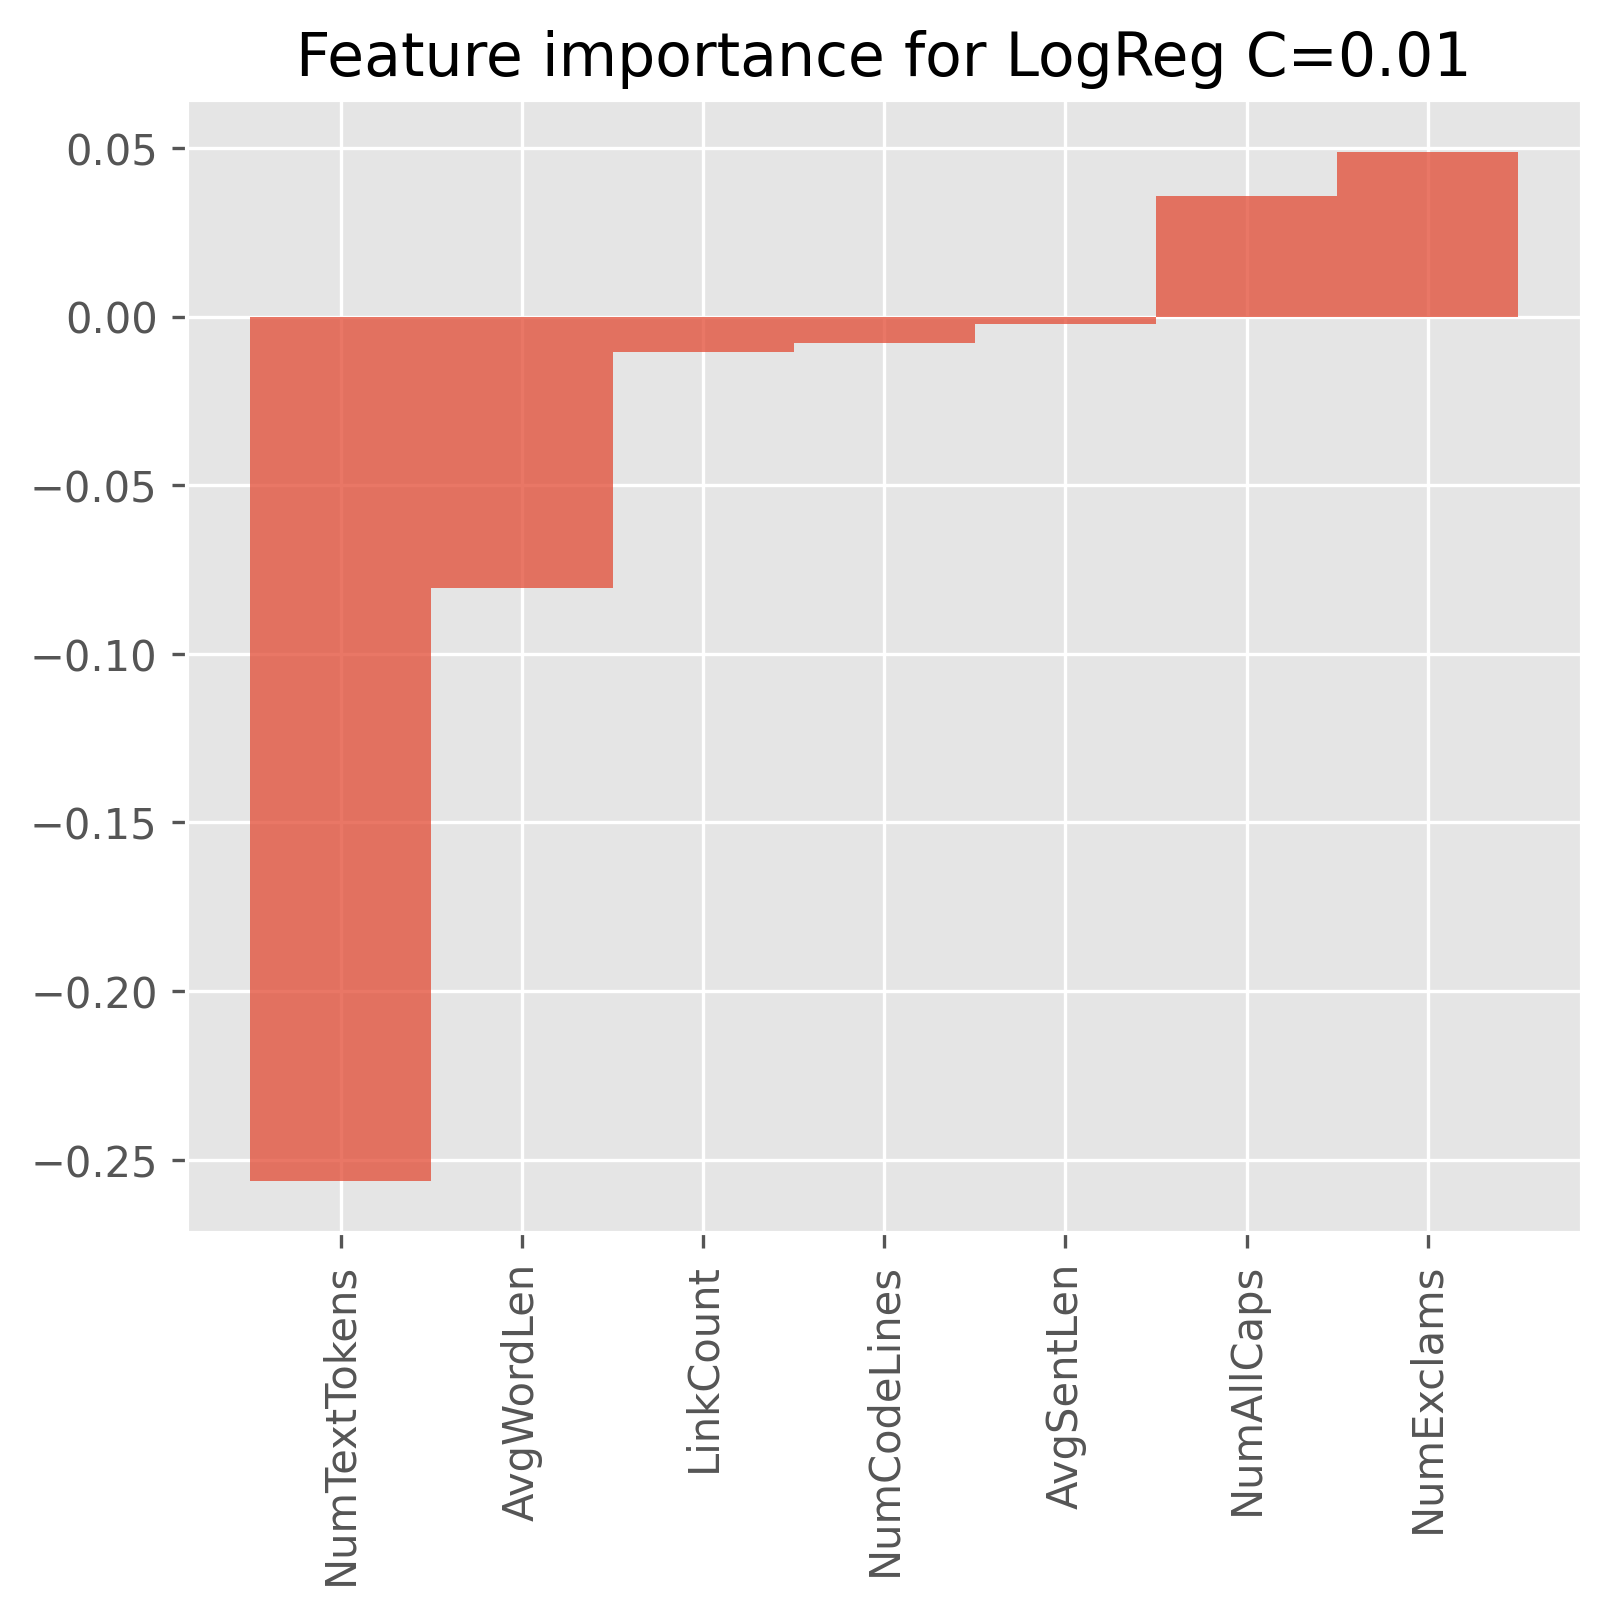

In [31]:
print("Poor answers...")
measure(LogisticRegression, {'C': C_best}, '09_poor_'+name, X_new, Y_poor, plot='poor', feature_names=feature_names);

In [32]:
precisions = good_results['med_precisions']
recalls = good_results['med_recalls']
thresholds = np.hstack([[0], good_results['med_thresholds']])

for precision in np.arange(0.77, 0.8, 0.01):
    thresh_idx = precisions >= precision
    print("P=%.2f R=%.2f thresh=%.2f" % (precisions[thresh_idx][0], recalls[thresh_idx][0], thresholds[thresh_idx][0]))

P=0.77 R=0.18 thresh=0.68
P=0.78 R=0.12 thresh=0.76
P=0.79 R=0.10 thresh=0.78
P=0.80 R=0.10 thresh=0.79


In [33]:
good_thresh = 0.66

In [34]:
clf = LogisticRegression(C=C_best)
clf.fit(X, Y)
print(clf.coef_)

[[ 0.26959228  0.0073371   0.01043131  0.00137593  0.07610769 -0.0406663
  -0.0464158 ]]


In [35]:
import pickle
pickle.dump(clf, open("logreg.dat", "wb"))
clf = pickle.load(open("logreg.dat", "rb"))
print(clf.coef_)

[[ 0.26959228  0.0073371   0.01043131  0.00137593  0.07610769 -0.0406663
  -0.0464158 ]]


In [37]:
good_post = (2, 1, 100, 5, 4, 1, 0)
poor_post = (1, 0, 10, 5, 6, 5, 4)
proba = clf.predict_proba([good_post, poor_post])
proba

array([[0.28992674, 0.71007326],
       [0.62624012, 0.37375988]])

In [38]:
proba >= good_thresh

array([[False,  True],
       [False, False]])

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [ ]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers])
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])

In [ ]:
Y = Y.astype(np.float32)[:, None]
bce_ceil = 1e-5
Y = Y * (1 - 2 * bce_ceil) + bce_ceil

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

In [ ]:
def create_dense(x, n_units, name, alpha=0.2):
    h = tf.layers.dense(x, n_units, activation=tf.nn.leaky_relu, name=name)
    return h

def create_output(x):
    h = tf.layers.dense(x, 1, activation=tf.nn.sigmoid, name="Output")
    return h

In [ ]:
tf.reset_default_graph()

n_epochs = 500
batch_size = 1000
steps = 10
layer1_size = 5

In [ ]:
X_tf = tf.placeholder(tf.float32, (None, 7), name="Input")
Y_ref_tf = tf.placeholder(tf.float32, (None, 1), name="Target_output")

h1 = create_dense(X_tf, layer1_size, name="Layer1")
Y_tf = create_output(h1)

loss = tf.reduce_mean(tf.square(Y_ref_tf - Y_tf))

grad_speed = .01
my_opt = tf.train.GradientDescentOptimizer(grad_speed)
train_step = my_opt.minimize(loss)

C:\Users\sauga_g\AppData\Local\Temp\ipykernel_7612\3901904062.py:2: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h = tf.layers.dense(x, n_units, activation=tf.nn.leaky_relu, name=name)
C:\Users\sauga_g\AppData\Local\Temp\ipykernel_7612\3901904062.py:6: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  h = tf.layers.dense(x, 1, activation=tf.nn.sigmoid, name="Output")


In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_vec = []
    for epoch in range(n_epochs):
        permut = np.random.permutation(len(X_train))
        for j in range(0, len(X_train), batch_size):
            batch = permut[j:j+batch_size]
            Xs = X_train[batch]
            Ys = Y_train[batch]
            
            sess.run(train_step, feed_dict={X_tf: Xs, Y_ref_tf: Ys})
        
        temp_loss = sess.run(loss, feed_dict={X_tf: X_train, Y_ref_tf: Y_train})
        loss_vec.append(temp_loss)
        if epoch % steps == steps - 1:
            print('Epoch #%i  loss = %s' % (epoch, temp_loss))

    predict_train = sess.run(Y_tf, feed_dict={X_tf: X_train})
    predict_test = sess.run(Y_tf, feed_dict={X_tf: X_test})

Epoch #9  loss = 0.49460813
Epoch #19  loss = 0.49176154
Epoch #29  loss = 0.34146318
Epoch #39  loss = 0.3262662
Epoch #49  loss = 0.29146534
Epoch #59  loss = 0.2535737
Epoch #69  loss = 0.27259925
Epoch #79  loss = 0.30166686
Epoch #89  loss = 0.24070953
Epoch #99  loss = 0.23730394
Epoch #109  loss = 0.24880917
Epoch #119  loss = 0.23591958
Epoch #129  loss = 0.23724328
Epoch #139  loss = 0.23940982
Epoch #149  loss = 0.23517457
Epoch #159  loss = 0.22949488
Epoch #169  loss = 0.22723624
Epoch #179  loss = 0.22685833
Epoch #189  loss = 0.22662348
Epoch #199  loss = 0.22695929
Epoch #209  loss = 0.24082571
Epoch #219  loss = 0.22797793
Epoch #229  loss = 0.22564112
Epoch #239  loss = 0.24443698
Epoch #249  loss = 0.22788641
Epoch #259  loss = 0.22512273
Epoch #269  loss = 0.23119496
Epoch #279  loss = 0.22654994
Epoch #289  loss = 0.22481158
Epoch #299  loss = 0.2247979
Epoch #309  loss = 0.2306419
Epoch #319  loss = 0.22477785
Epoch #329  loss = 0.22867775
Epoch #339  loss = 0.2264

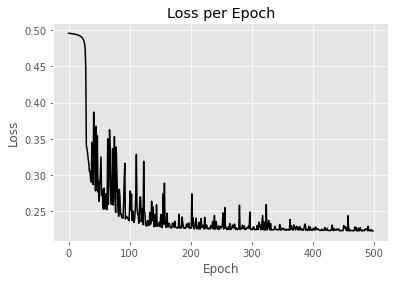

In [ ]:
plt.plot(loss_vec, 'k-')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
save_png('tf_classification_loss')

In [ ]:
from sklearn.metrics import accuracy_score

score = accuracy_score(Y_train > .5, predict_train > .5)
print("Score (on training data): %.2f" % score)
score = accuracy_score(Y_test > .5, predict_test > .5)
print("Score (on testing data): %.2f" % score)

Score (on training data): 0.65
Score (on testing data): 0.66


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

        Poor       0.63      0.73      0.68      7995
        Good       0.68      0.56      0.62      8005

    accuracy                           0.65     16000
   macro avg       0.65      0.65      0.65     16000
weighted avg       0.65      0.65      0.65     16000

Confusion matrix, without normalization
[[5864 2131]
 [3501 4504]]


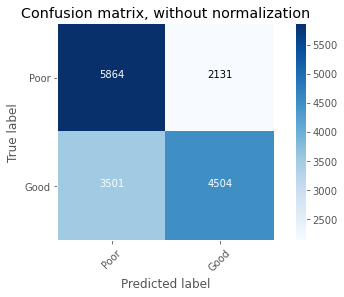

              precision    recall  f1-score   support

        Poor       0.63      0.75      0.69      2005
        Good       0.69      0.56      0.62      1995

    accuracy                           0.66      4000
   macro avg       0.66      0.66      0.65      4000
weighted avg       0.66      0.66      0.65      4000

Confusion matrix, without normalization
[[1506  499]
 [ 877 1118]]


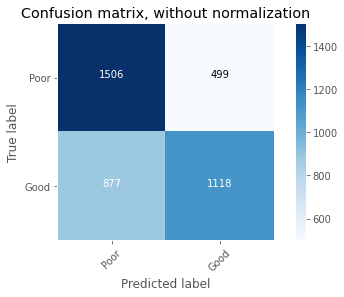

In [ ]:
class_names = ["Poor", "Good"]
from sklearn import metrics
print(metrics.classification_report(Y_train > .5, predict_train > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_train > .5, predict_train > .5), classes=class_names,
                      title='Confusion matrix, without normalization')
plt.grid(False)
save_png('tf_classification_train')
plt.show()
print(metrics.classification_report(Y_test > .5, predict_test > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_test > .5, predict_test > .5), classes=class_names,
                      title='Confusion matrix, without normalization')
plt.grid(False)
save_png('tf_classification_test')